In [1]:
import psycopg2
import datetime as dt
from dateutil.relativedelta import relativedelta
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
db_name = "energy"
db_user = "dawki"
db_pword_file = "C:\\Users\\dawki\\OneDrive\\Archive\\2019\\Documents\\private.txt"
with open(db_pword_file) as f:
    db_pword = f.read()

In [3]:
## Connect to DB
dbc = psycopg2.connect(user=db_user,
                        password=db_pword,
                        host="127.0.0.1",
                        port="5432",
                        database=db_name)
cursor = dbc.cursor()

In [4]:
regions= ['NSW1', 'QLD1', 'SA1', 'TAS1', 'VIC1']
start = dt.datetime(2020,1,1)
end = dt.datetime(2021,1,1)

In [17]:
pd.read_sql(
    f"select * from dim_batch",
    dbc
    )

id  network_id  region_id month_start api_version  \
0      1           1          1  2019-01-01       3.7.8   
1      2           1          1  2019-02-01       3.7.8   
2      3           1          1  2019-03-01       3.7.8   
3      4           1          1  2019-04-01       3.7.8   
4      5           1          1  2019-05-01       3.7.8   
..   ...         ...        ...         ...         ...   
146  160           1          5  2021-04-01       3.7.8   
147  161           1          5  2021-05-01       3.7.8   
148  162           1          5  2021-06-01       3.7.8   
149  163           1          5  2021-07-01       3.7.8   
150  165           1          5  2021-09-01       3.7.8   

                    pull_date  price_interval  power_interval price_units  \
0   2021-09-06 11:47:11+00:00 0 days 00:30:00 0 days 00:05:00     AUD/MWh   
1   2021-09-06 11:47:35+00:00 0 days 00:30:00 0 days 00:05:00     AUD/MWh   
2   2021-09-06 11:47:58+00:00 0 days 00:30:00 0 days 00:05:00     AUD/MWh   
3   2021-09-06 11:48:18+00:00 0 days 00:30:00 0 days 00:05:00     AUD/MWh   
4   2021-09-06 11:48:39+00:00 0 days 00:30:00 0 days 00:05:00     AUD/MWh   
..                        ...             ...             ...         ...   
146 2021-09-06 22:35:12+00:00 0 days 00:30:00 0 days 00:05:00     AUD/MWh   
147 2021-09-06 22:35:32+00:00 0 days 00:30:00 0 days 00:05:00     AUD/MWh   
148 2021-09-06 22:35:50+00:00 0 days 00:30:00 0 days 00:05:00     AUD/MWh   
149 2021-09-06 22:36:21+00:00 0 days 00:30:00 0 days 00:05:00     AUD/MWh   
150 2021-09-06 22:36:43+00:00 0 days 00:30:00 0 days 00:05:00     AUD/MWh   

    power_units  
0            MW  
1            MW  
2            MW  
3            MW  
4            MW  
..          ...  
146          MW  
147          MW  
148          MW  
149          MW  
150          MW  

[151 rows x 10 columns]

In [5]:
spot_price = {}
for region in regions: 
    regional_spot_price = pd.read_sql(
    f"select interval_start, cast(price as numeric)  \
    from fact_price, dim_batch, dim_region \
    where dim_batch.id=batch_id AND dim_region.id = region_id AND dim_region.code = '{region}' AND fact_price.interval_start >= '{start}' AND fact_price.interval_start < '{end}'",
    dbc
    )
    spot_price[region] = regional_spot_price

# nsw_spot_price = nsw_spot_price.set_index("interval_start")

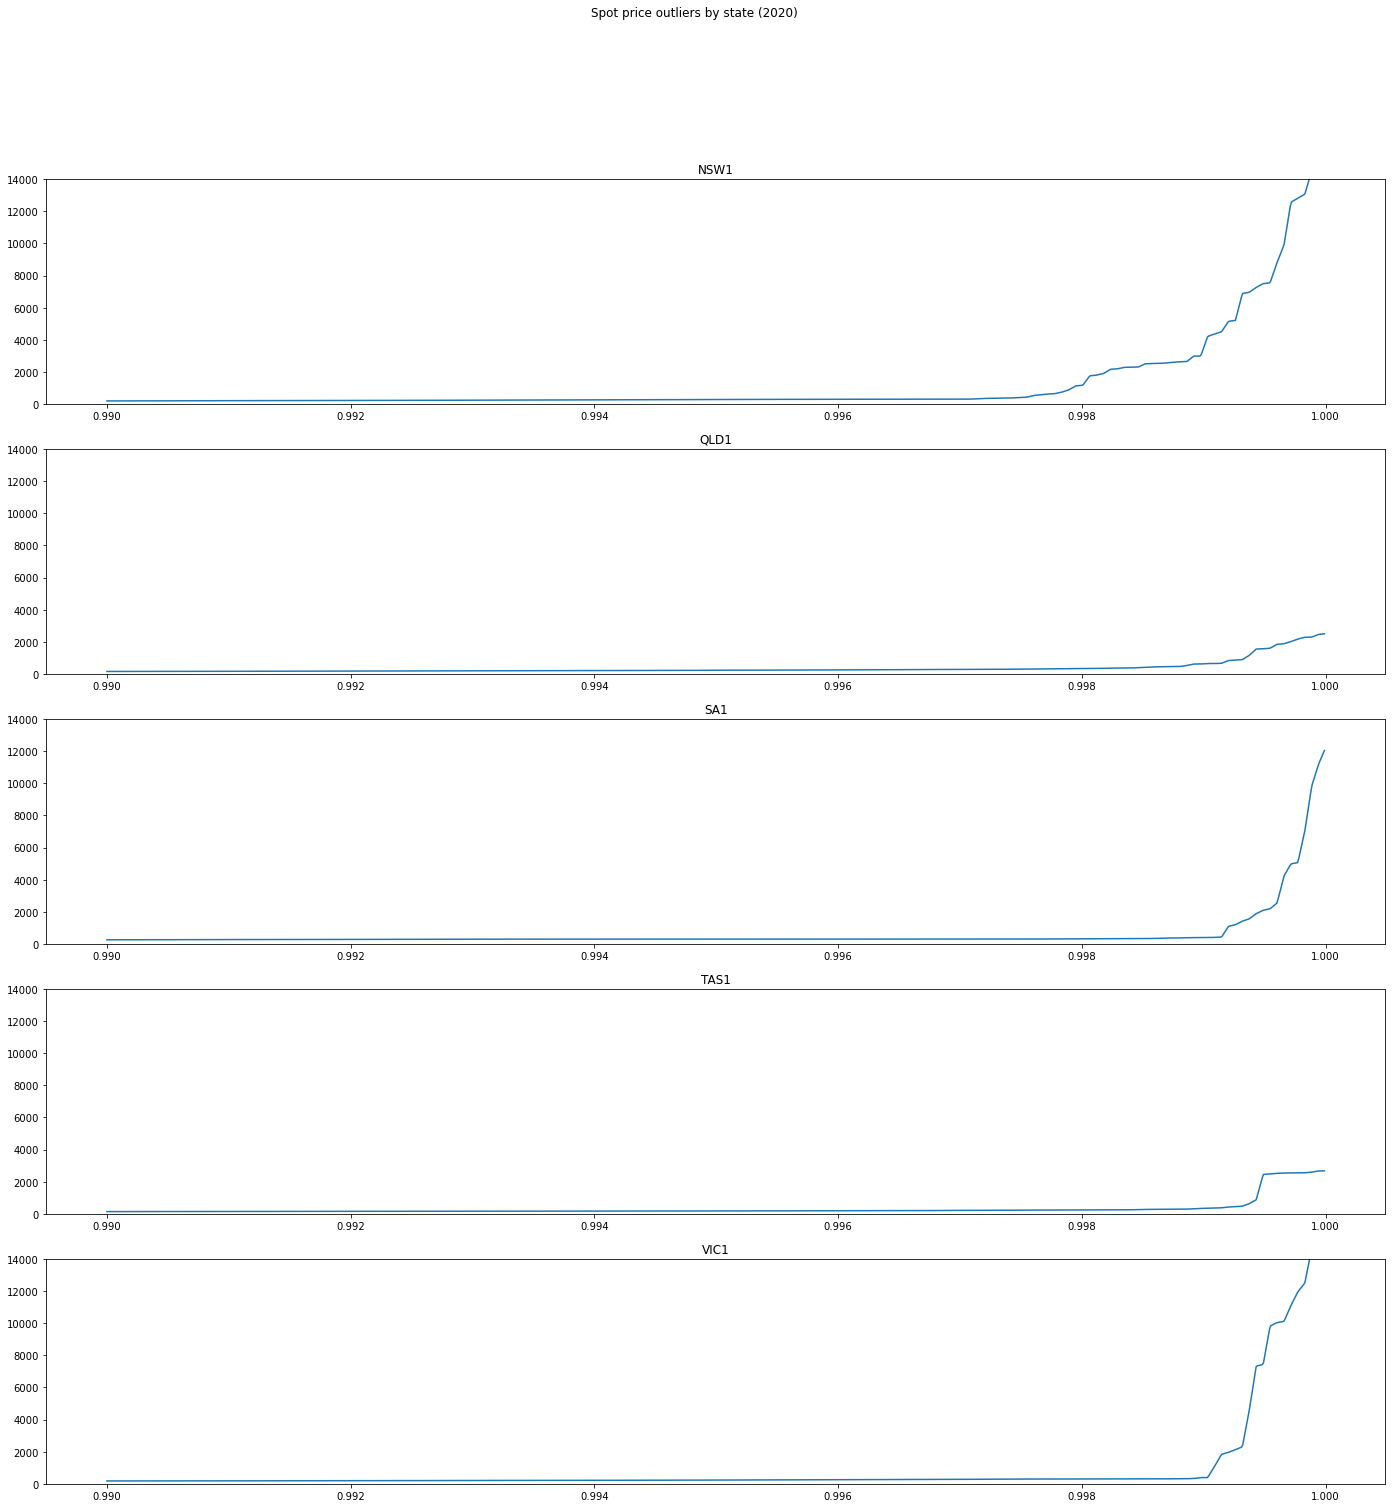

In [6]:
fig, ax = plt.subplots(5,1,figsize=(24,24))
fig.suptitle("Spot price outliers by state (2020)")
for p in range(5):
    ax[p].set_title(regions[p])
    ax[p].set_ylim(0,14000)
    ax[p].plot([0.99+q/100000 for q in range(1000)], [spot_price[regions[p]].quantile(0.99+q/100000) for q in range(1000)])

In [7]:
((24*2*365)*0.001)/2

8.76

## Spot price with cap

In [8]:
cap = 500
spot_price_capped = {}
for region in regions: 
    spot_price_capped[region] = spot_price[region]
    spot_price_capped[region]["price"] = spot_price_capped[region]["price"].where(spot_price[region]["price"] <= cap, cap) 

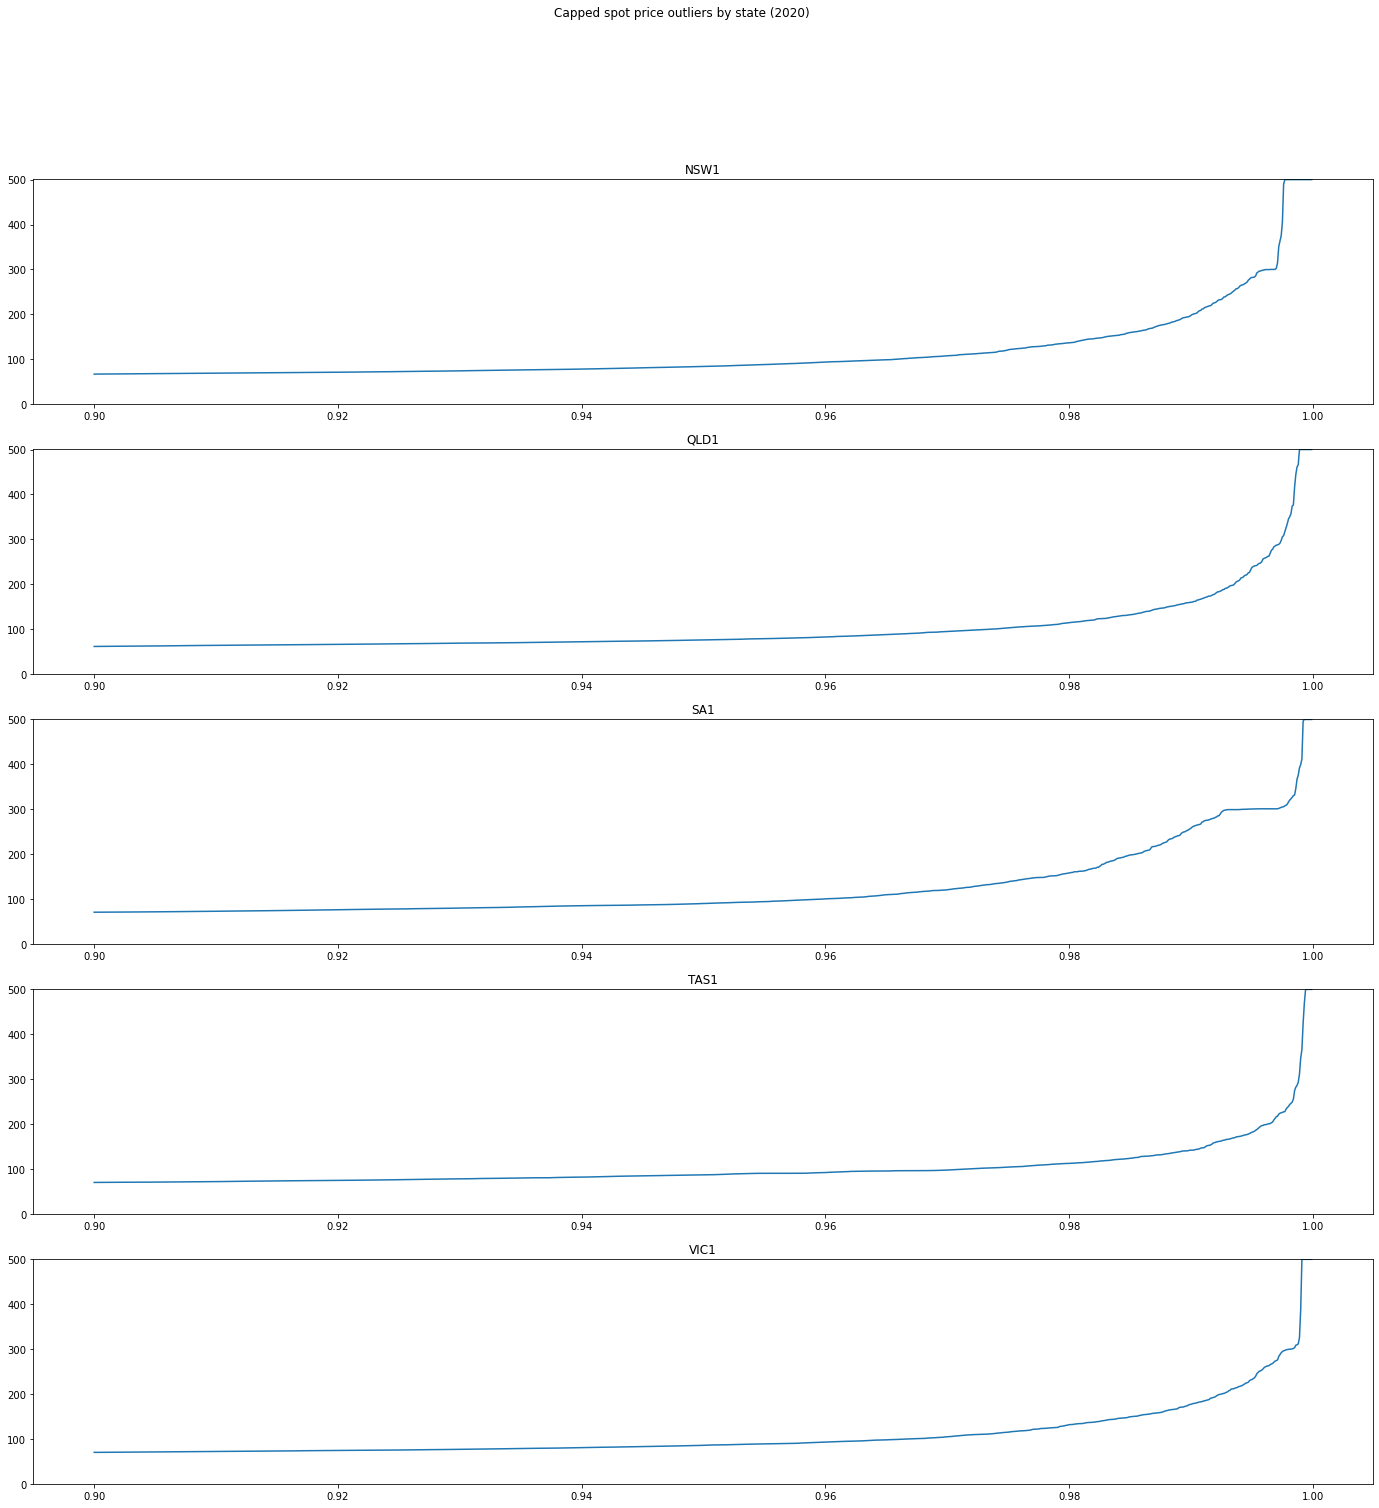

In [9]:
fig, ax = plt.subplots(5,1,figsize=(24,24))
fig.suptitle("Capped spot price outliers by state (2020)")
for p in range(5):
    ax[p].set_title(regions[p])
    ax[p].set_ylim(0,501)
    ax[p].plot([0.9+q/10000 for q in range(1000)], [spot_price_capped[regions[p]].quantile(0.9+q/10000) for q in range(1000)])

In [10]:
(24*2*365*0.01)/2

87.60000000000001

In [11]:
high_price = 200
high_price_events = {}
for region in regions: 
    high_price_events[region] = spot_price_capped[region][spot_price_capped[region]["price"]>=high_price]
    high_price_events[region]["date"] = pd.to_datetime(high_price_events[region]["interval_start"]).dt.date

<ipython-input-11-e29069df64f2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_price_events[region]["date"] = pd.to_datetime(high_price_events[region]["interval_start"]).dt.date
<ipython-input-11-e29069df64f2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_price_events[region]["date"] = pd.to_datetime(high_price_events[region]["interval_start"]).dt.date
<ipython-input-11-e29069df64f2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [12]:
high_price_days = {}
for region in regions:
    high_price_days[region] = high_price_events[region]["date"].unique()

Text(0.5, 0, 'month')

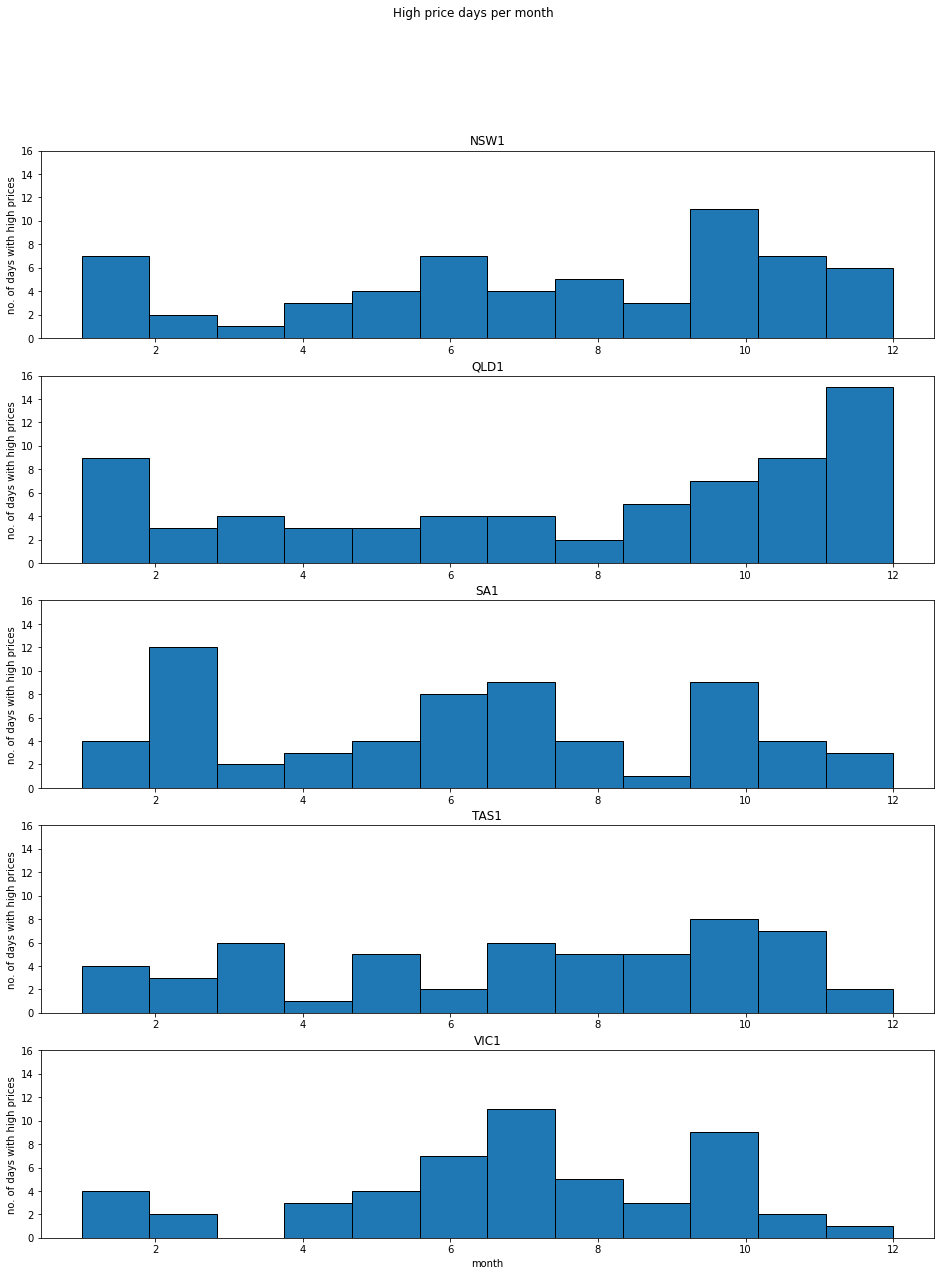

In [13]:
fig, ax = plt.subplots(5,1,figsize=(16,20))
fig.suptitle("High price days per month")
for i in range(5):
    ax[i].hist([hpd.month for hpd in high_price_days[regions[i]]],bins=12, edgecolor='black')
    ax[i].set_title(regions[i])
    ax[i].set_ylabel('no. of days with high prices')
    ax[i].set_ylim(0,16)
ax[4].set_xlabel('month')

In [14]:
for region in regions:
    print(f"{region} had high prices on {len(high_price_days[region])} days")

NSW1 had high prices on 60 days
QLD1 had high prices on 68 days
SA1 had high prices on 63 days
TAS1 had high prices on 54 days
VIC1 had high prices on 51 days


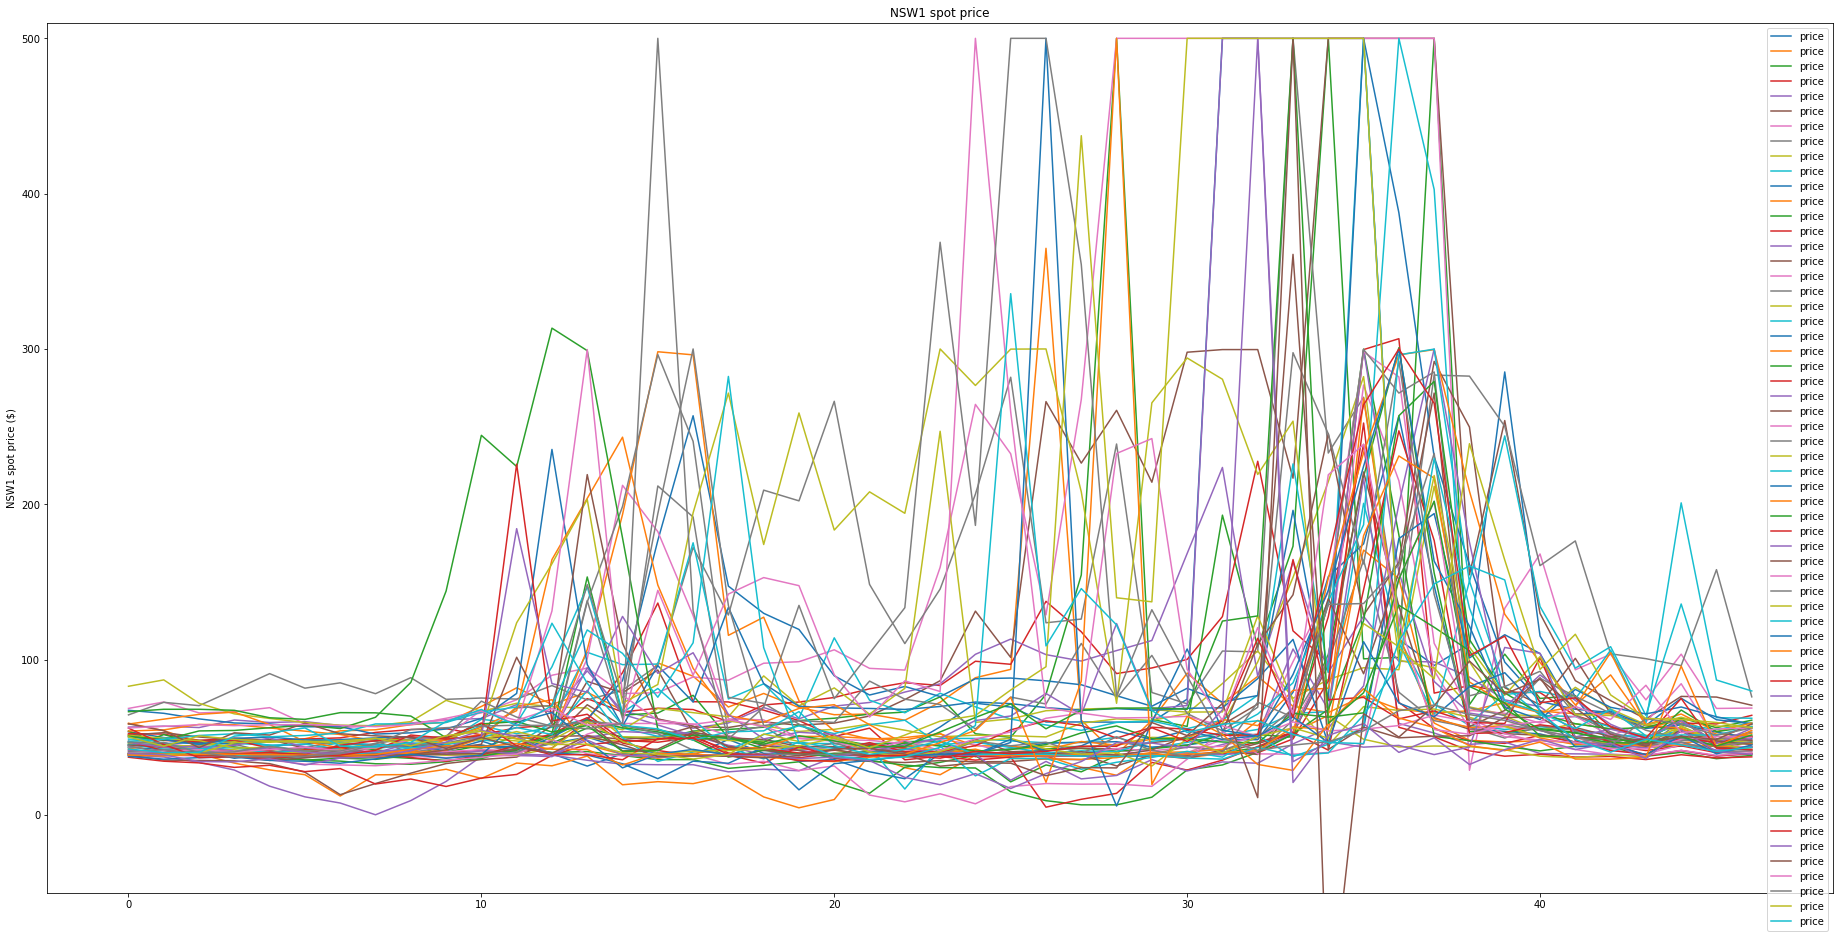

In [15]:
region = "NSW1"
fig, ax = plt.subplots(figsize=(32,16))
ax.set_title(f'{region} spot price')
ax.set_ylabel(f'{region} spot price ($)')
ax.set_ylim(-50,cap+10)
for hp_day in high_price_days[region]:
    start = pd.to_datetime(hp_day)
    end = pd.to_datetime(hp_day + dt.timedelta(days=1))
    day_spot_price = spot_price_capped[region][(spot_price_capped[region]["interval_start"]>start) & (spot_price_capped[region]["interval_start"]<end)]
    day_spot_price[["price"]].reset_index(drop=True, inplace=False).plot(ax=ax)

<ipython-input-16-d1de6abfa0c8>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(16,8))


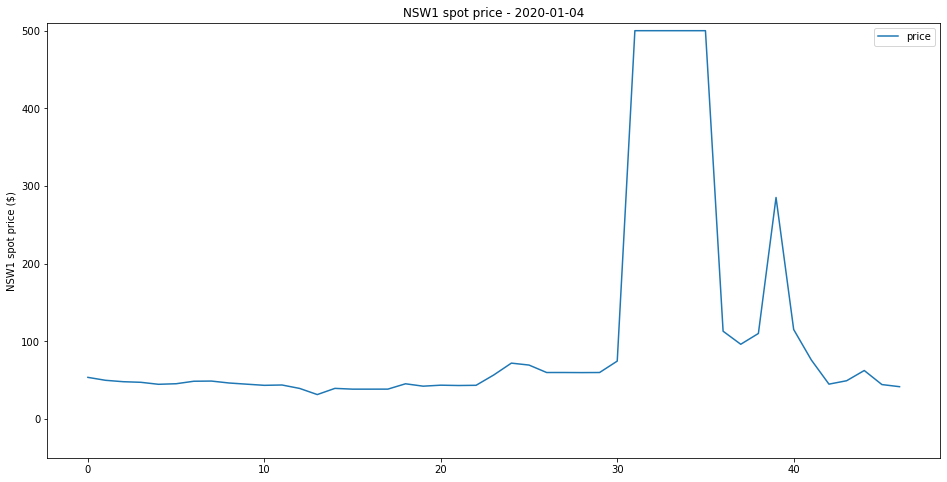

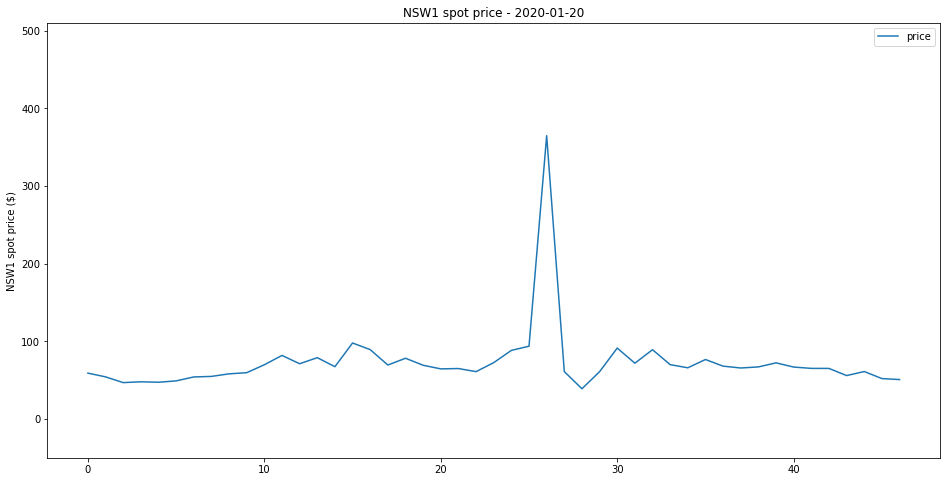

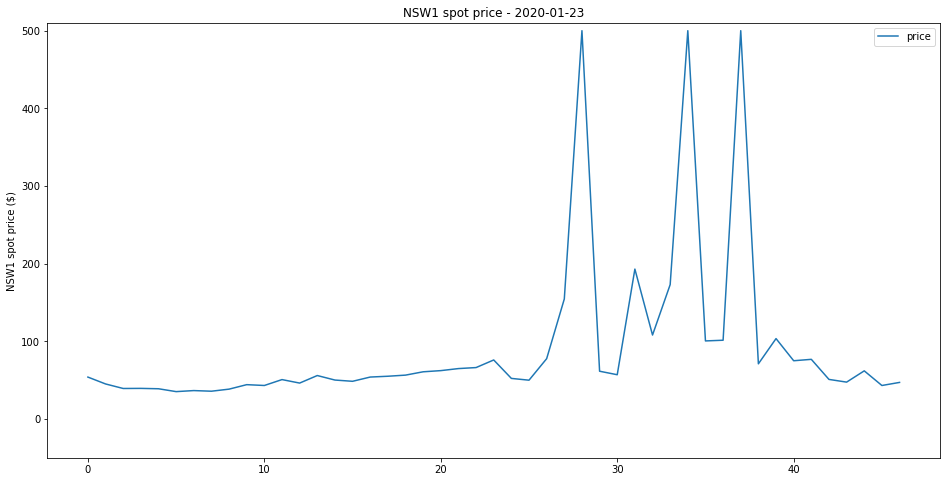

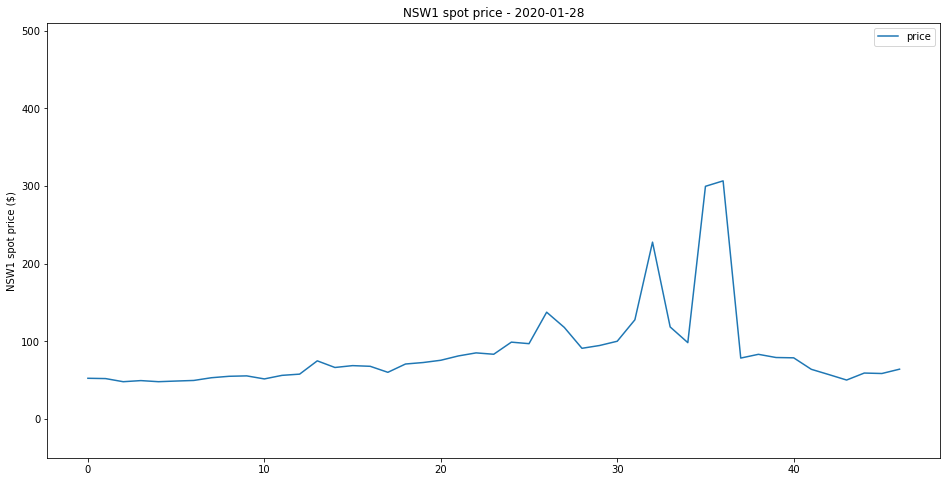

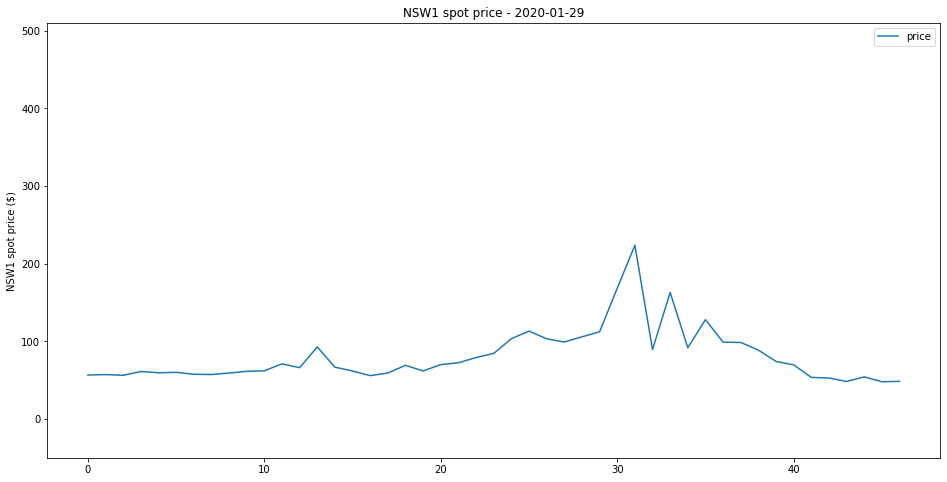

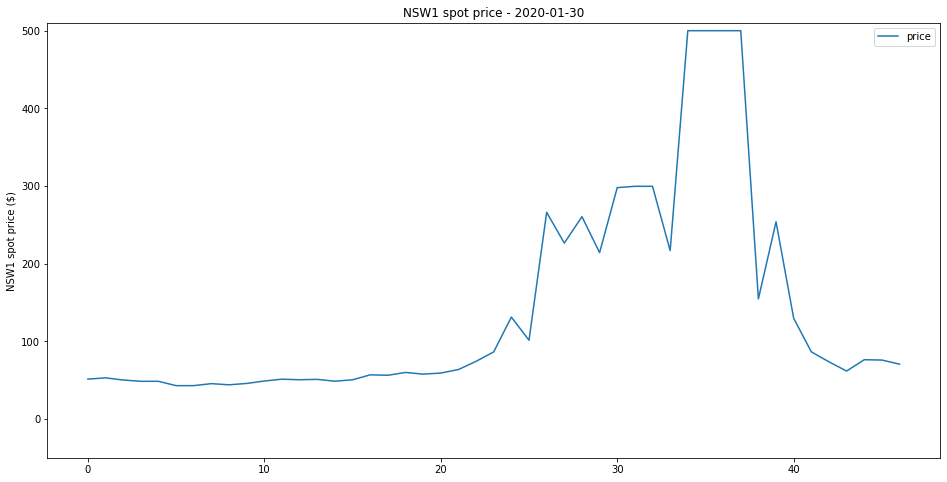

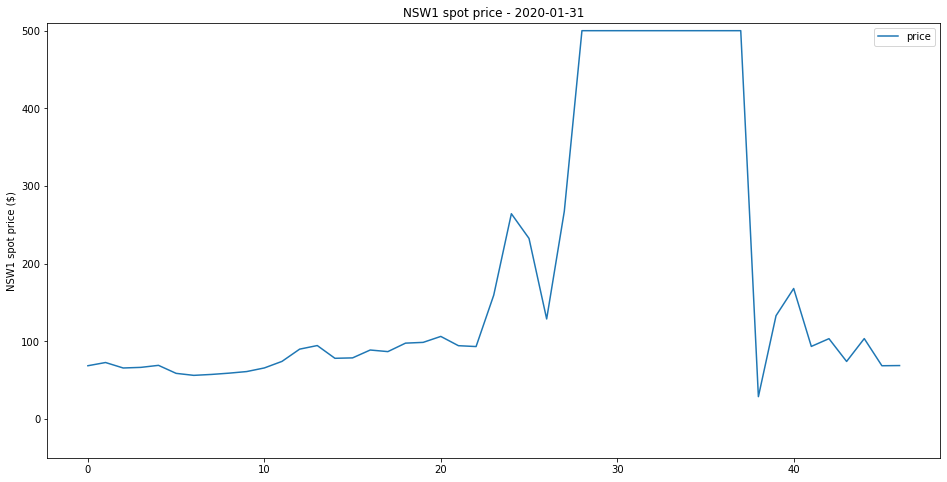

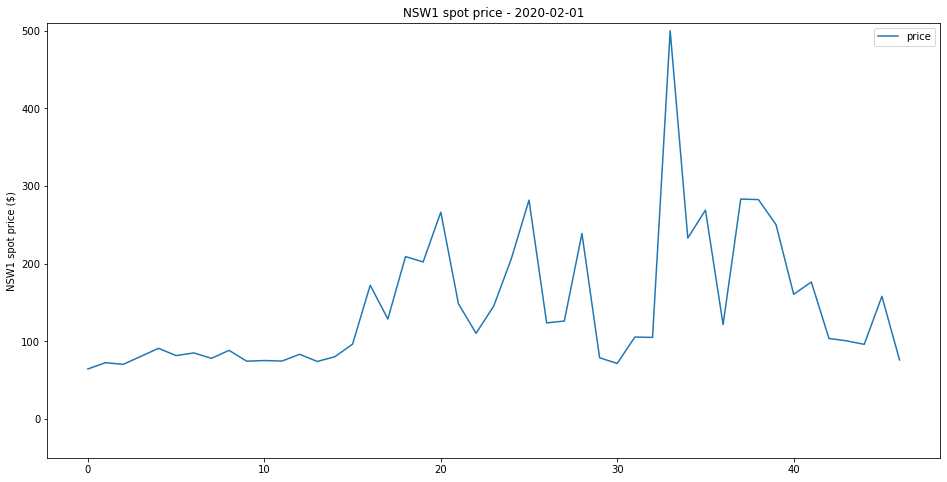

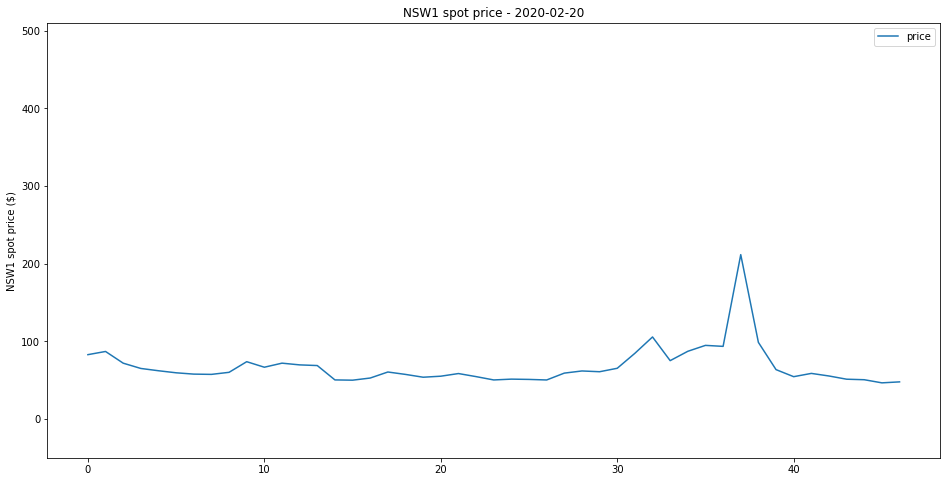

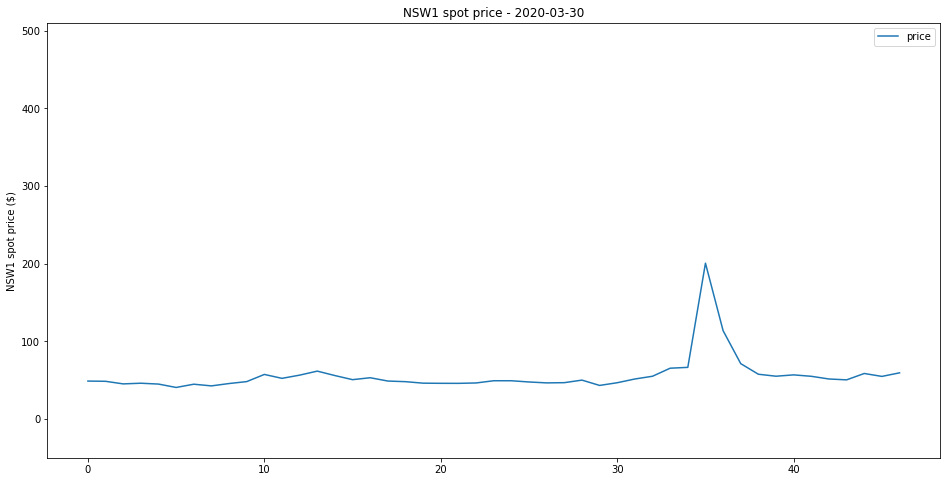

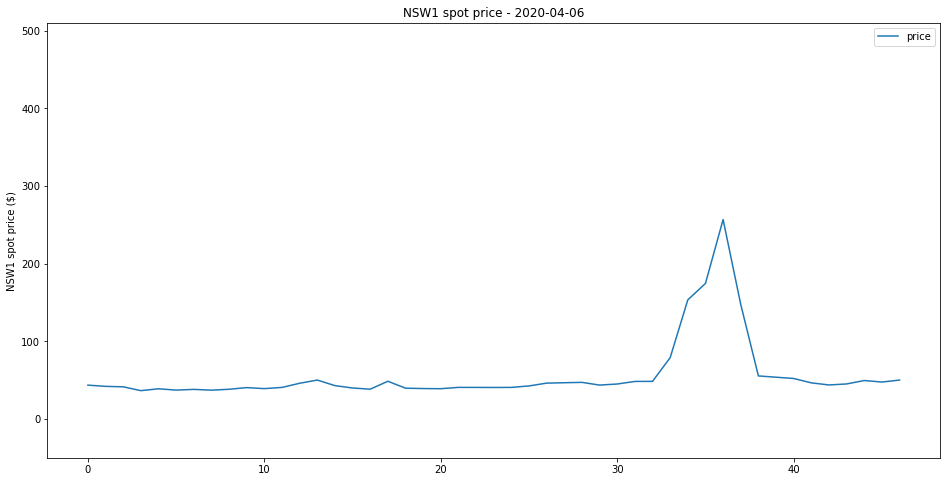

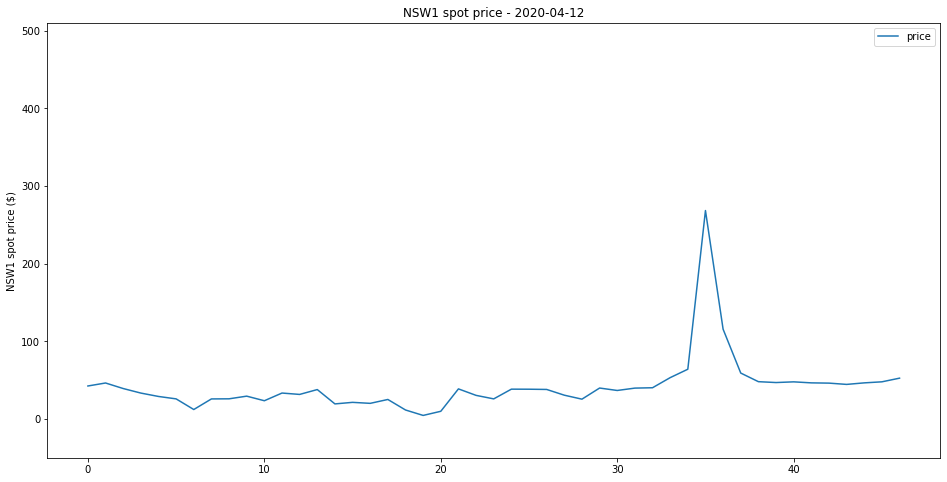

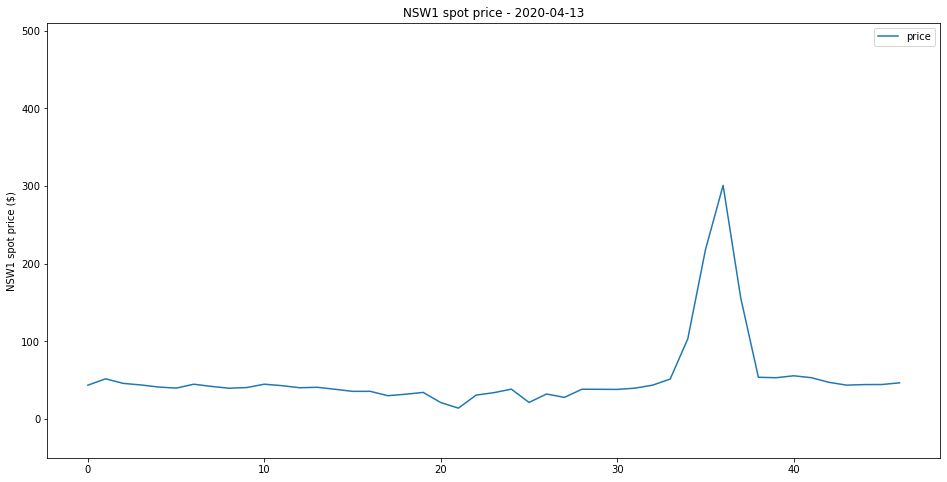

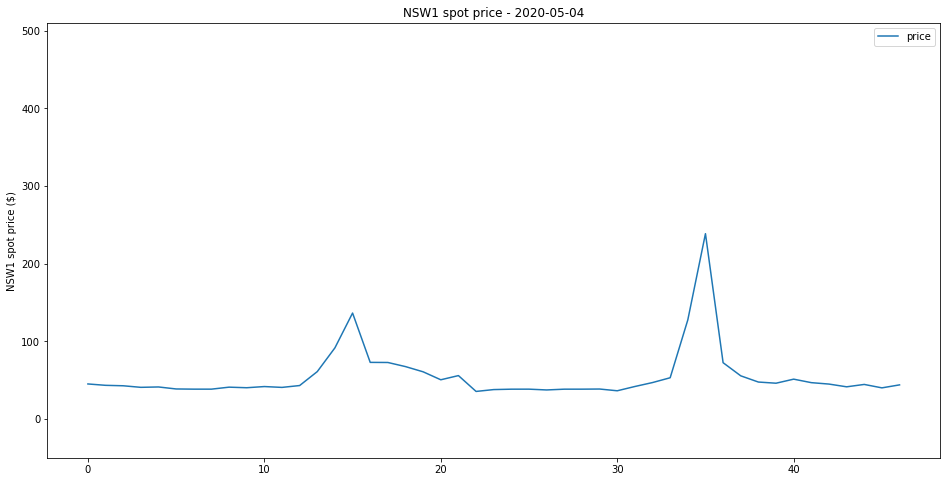

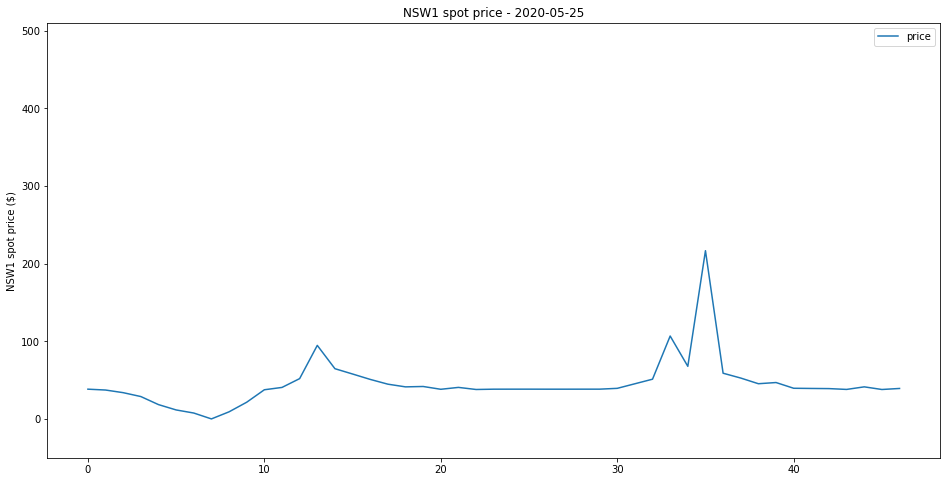

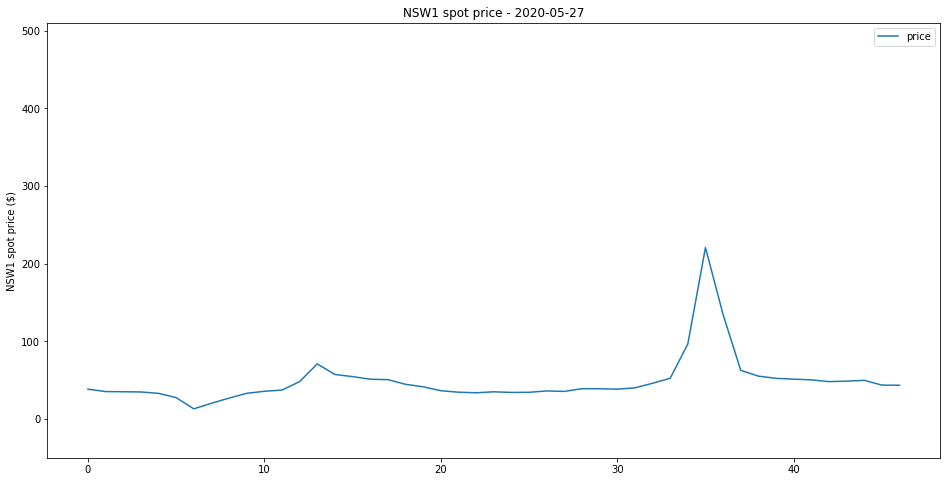

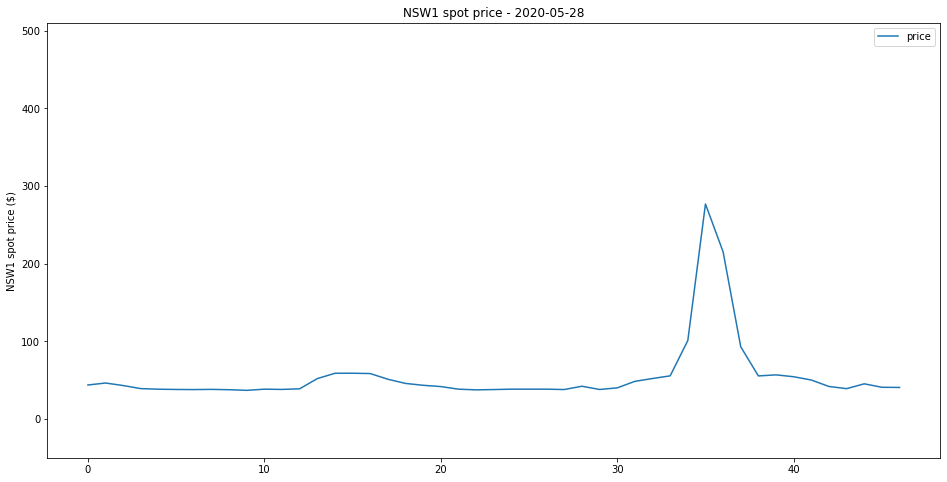

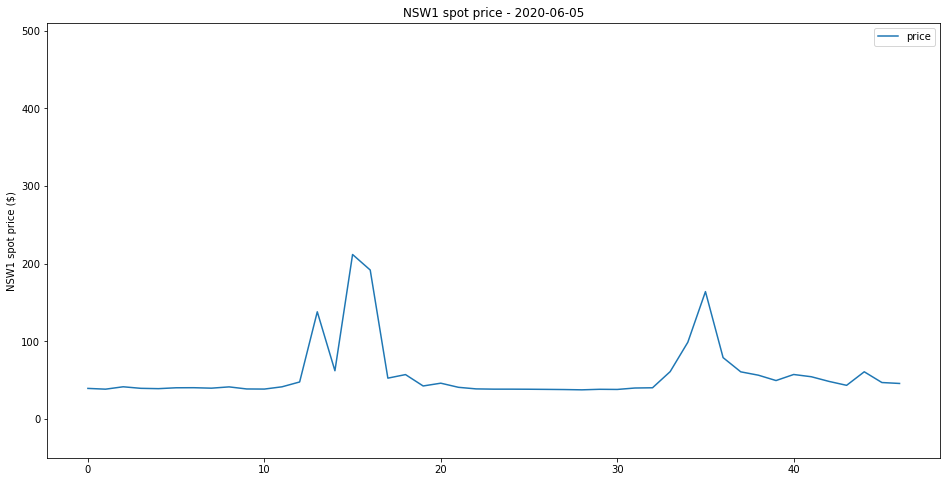

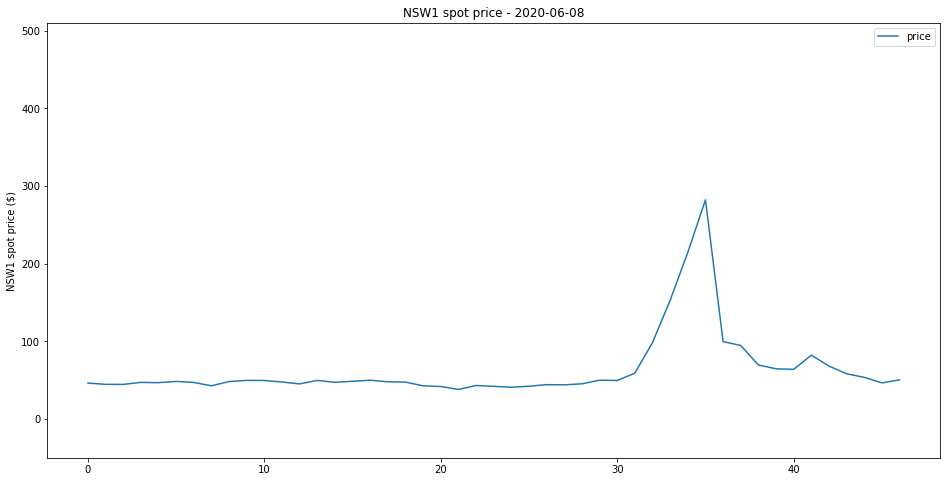

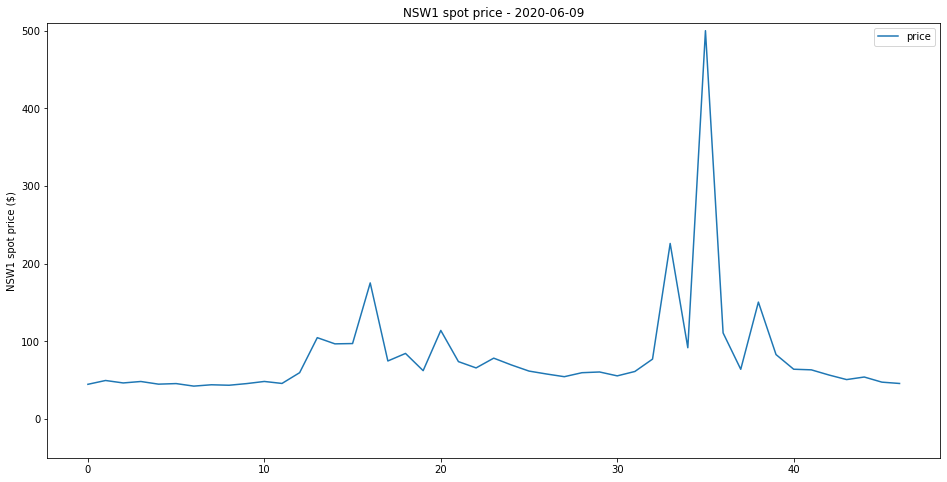

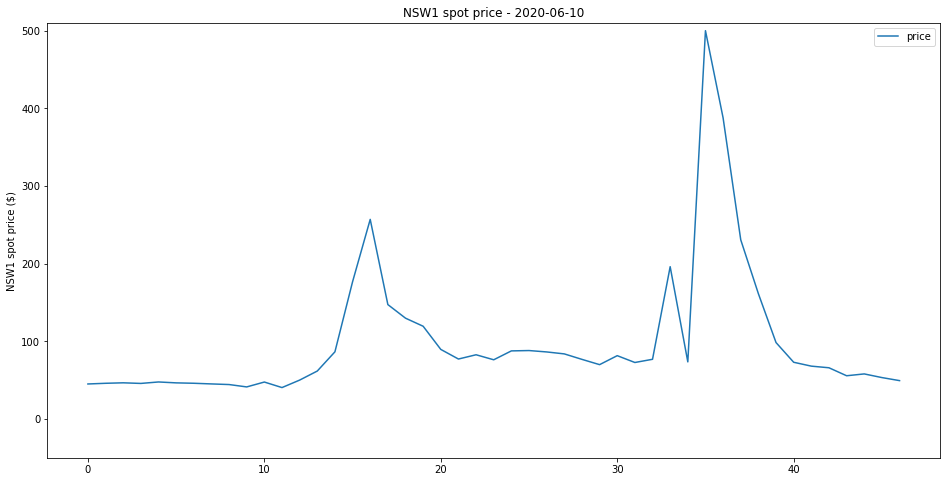

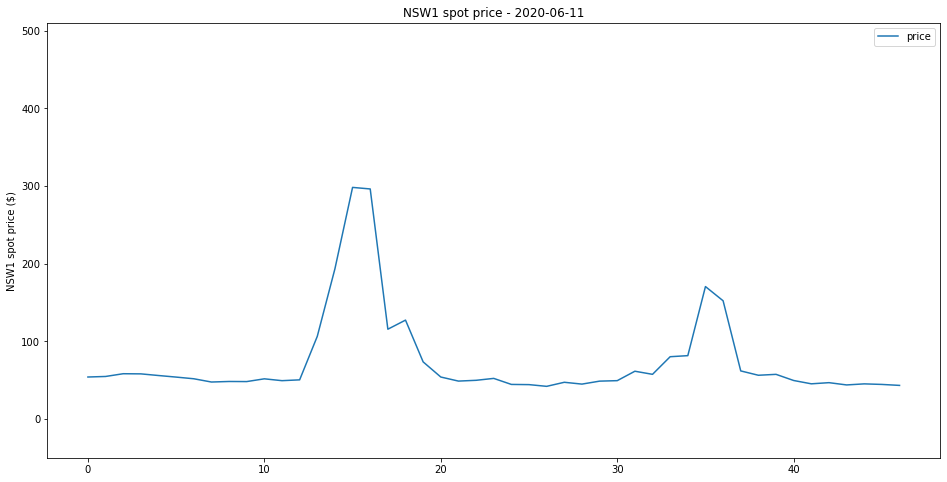

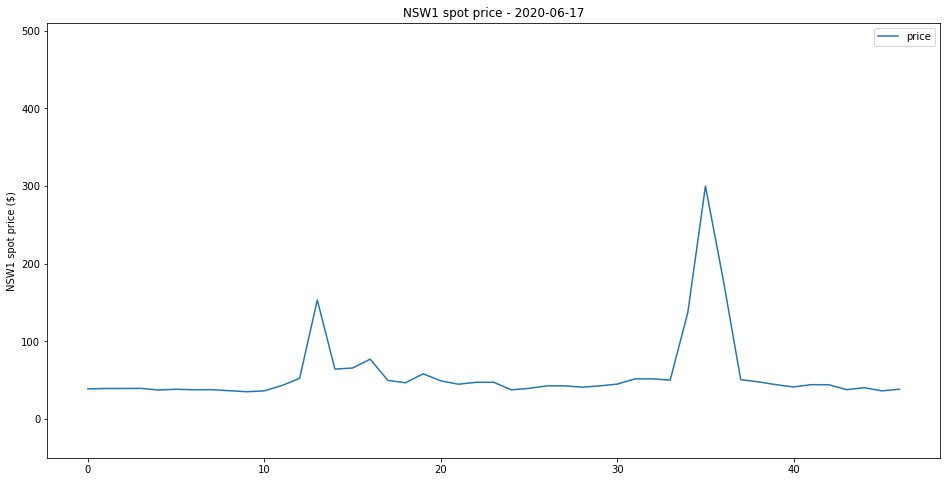

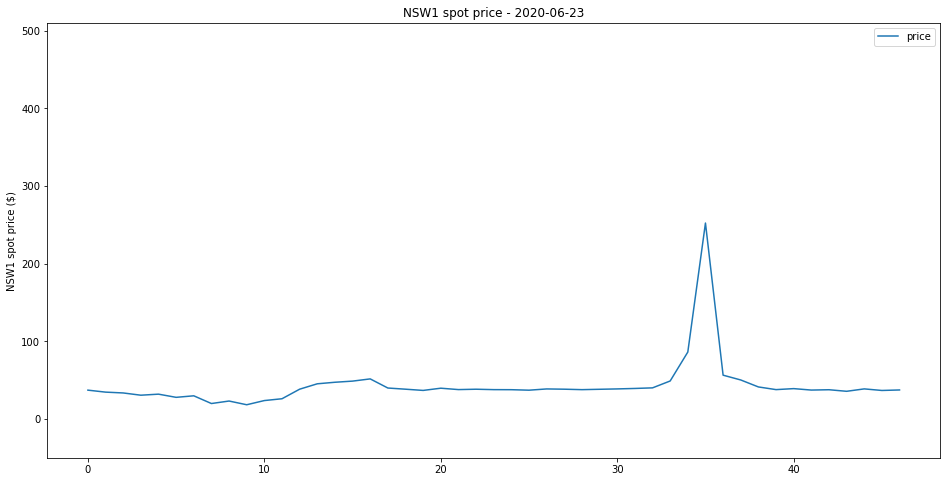

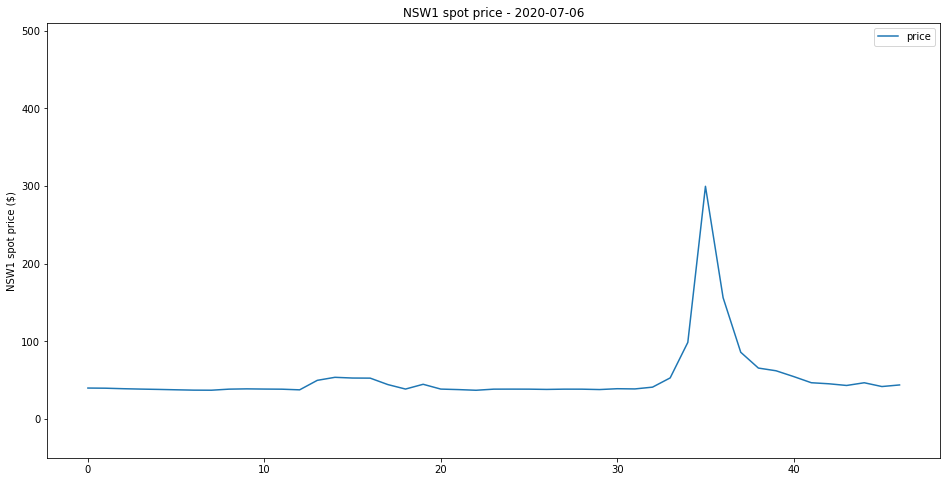

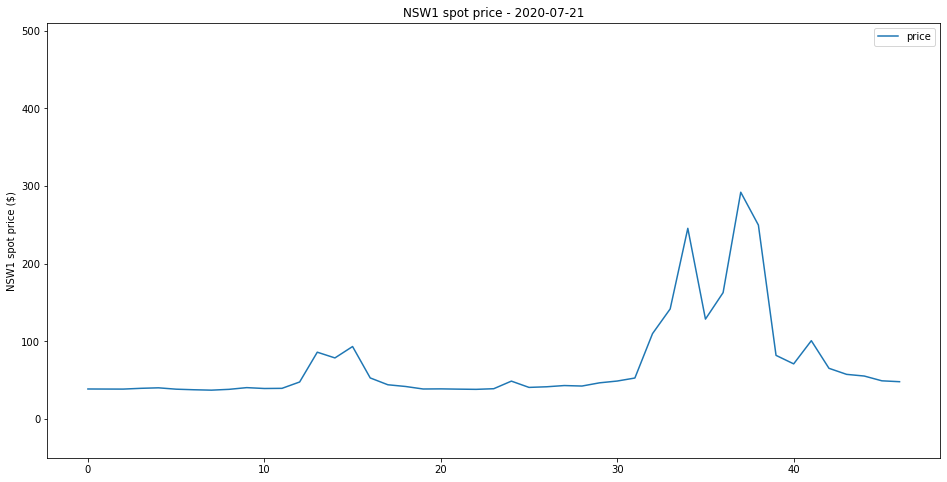

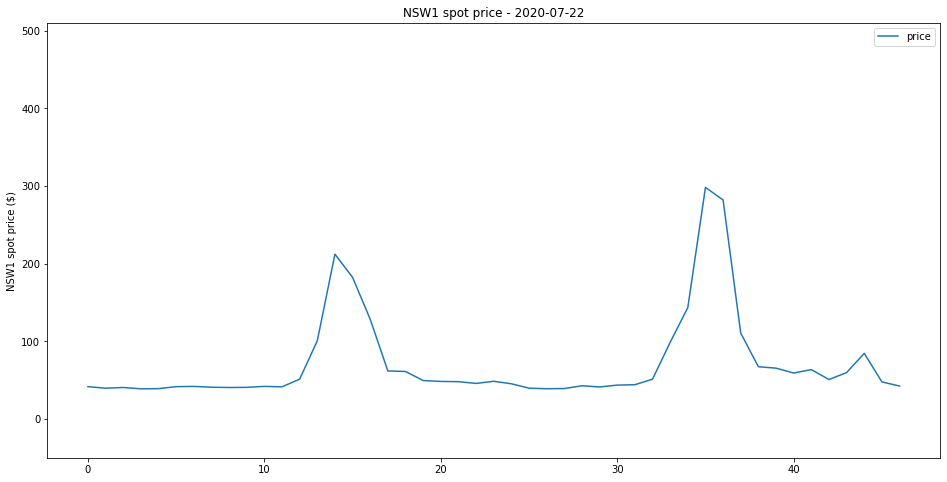

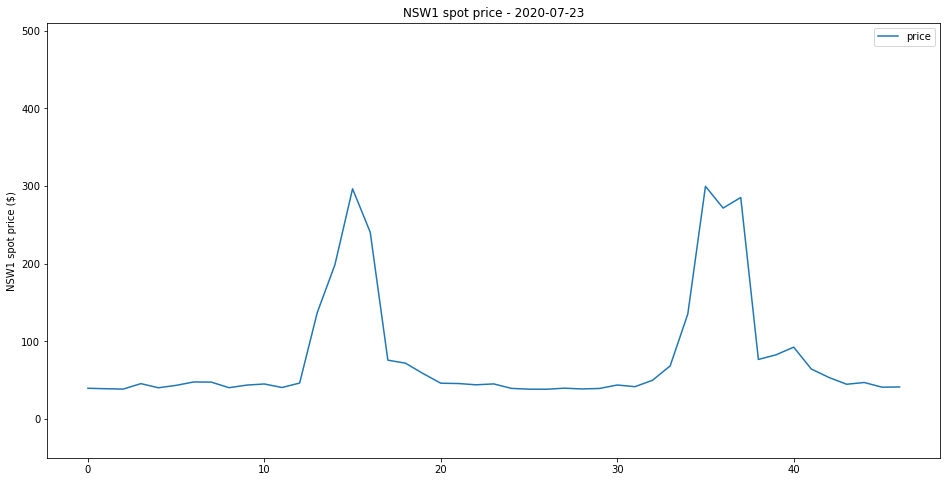

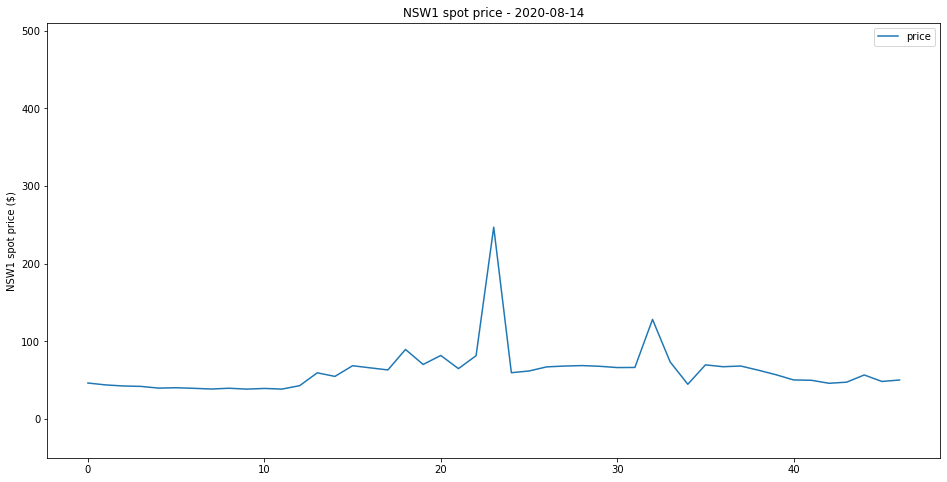

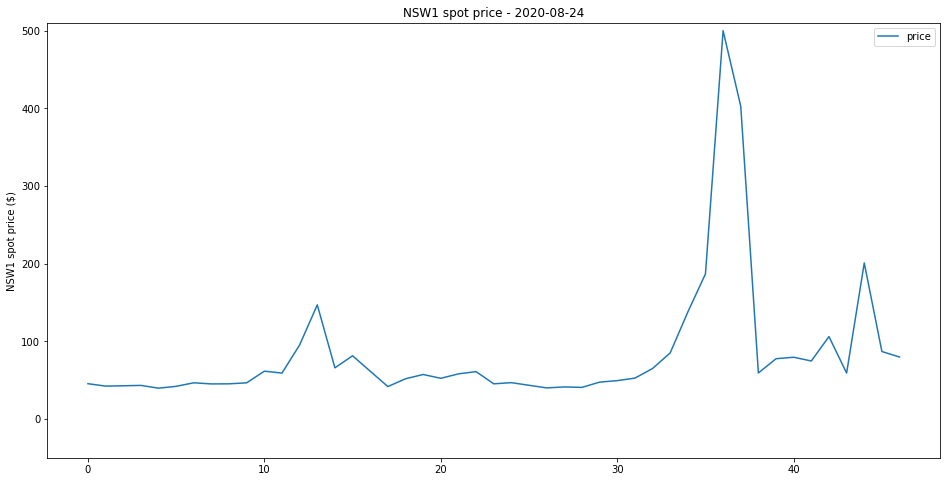

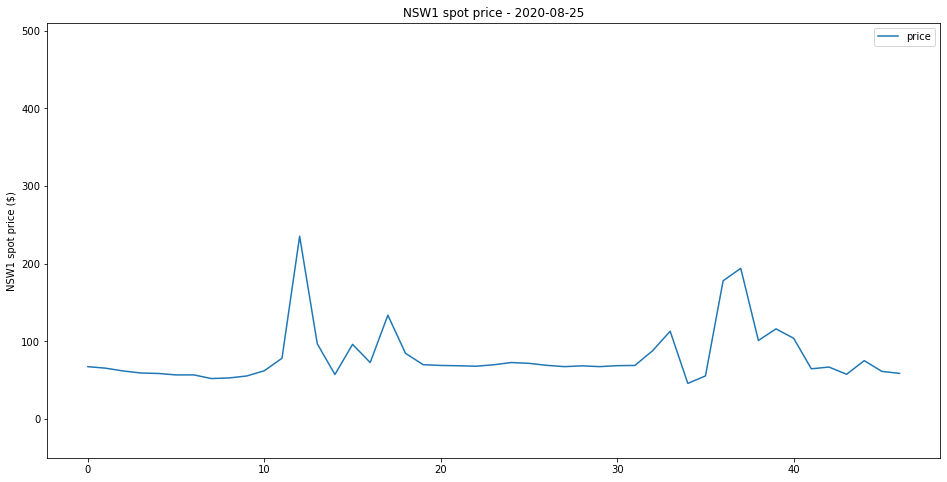

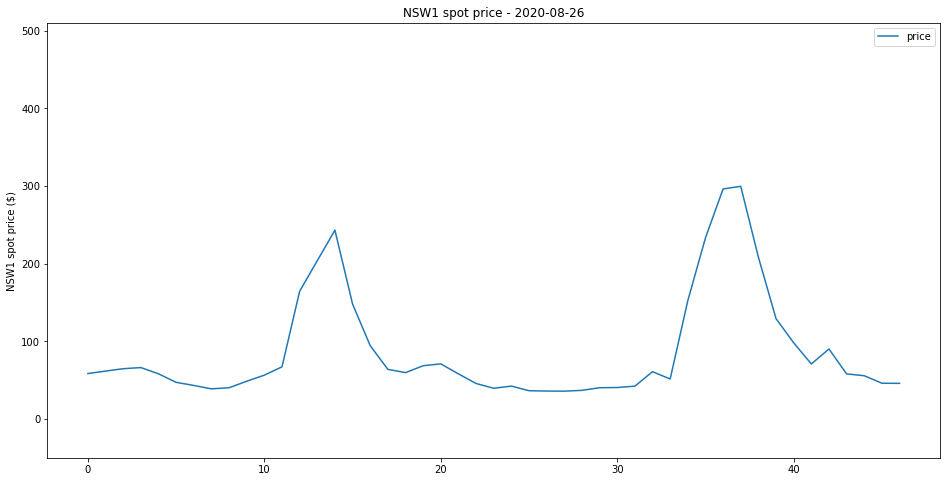

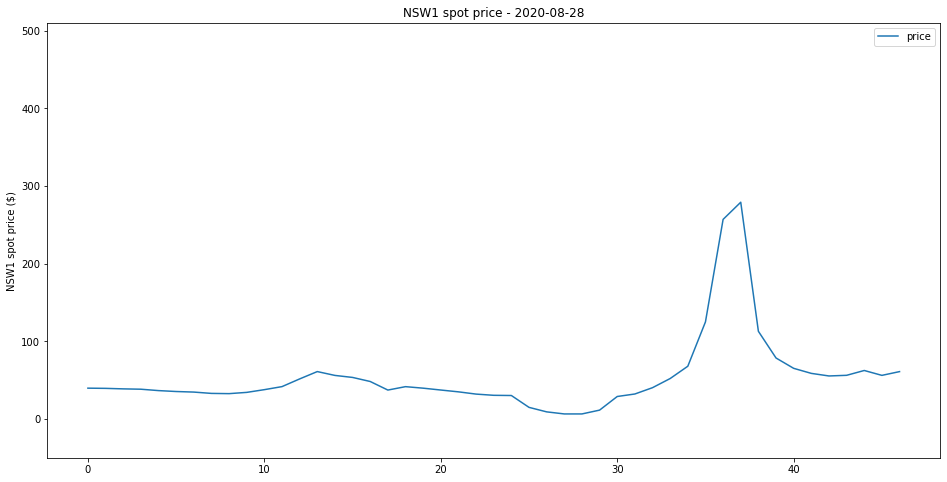

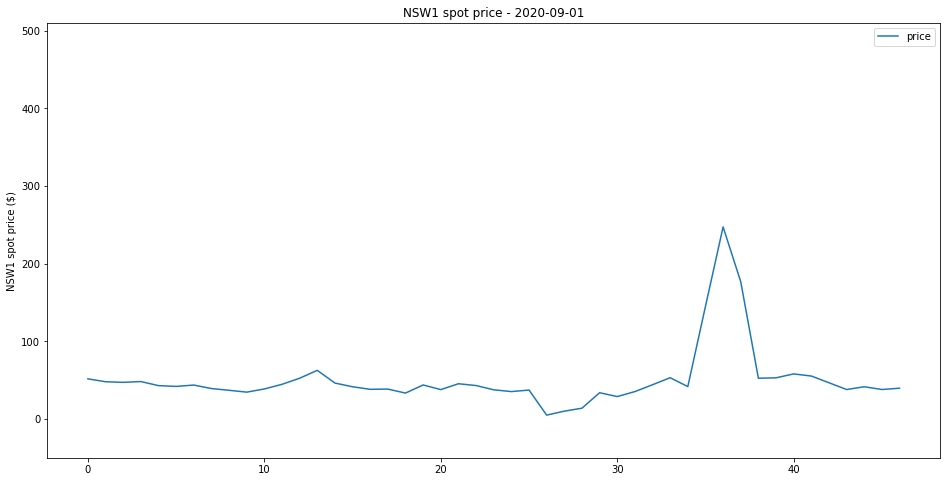

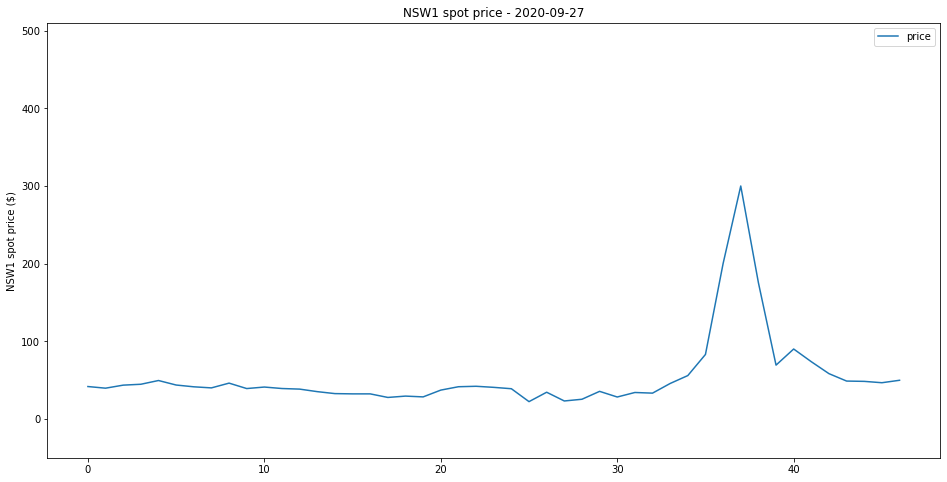

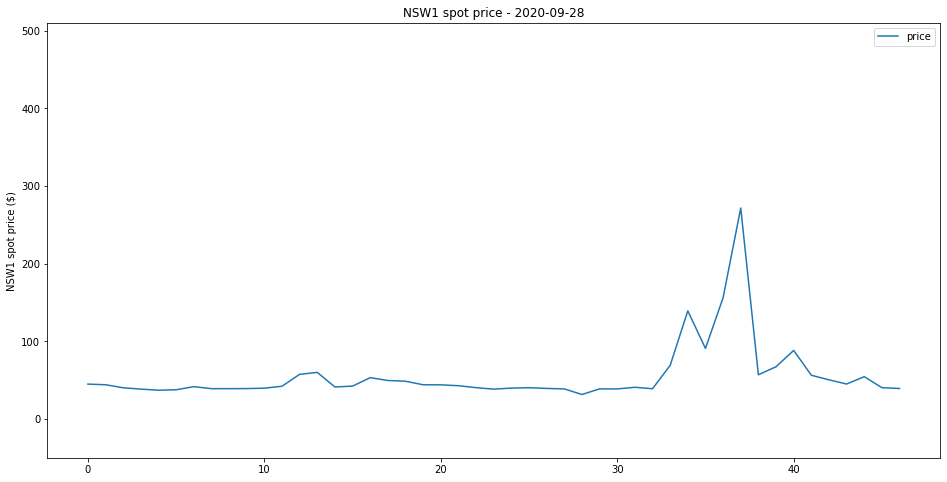

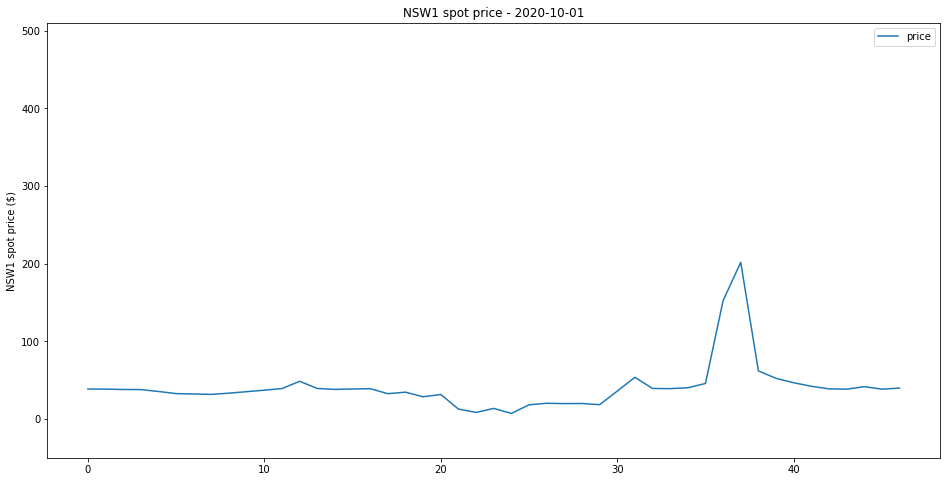

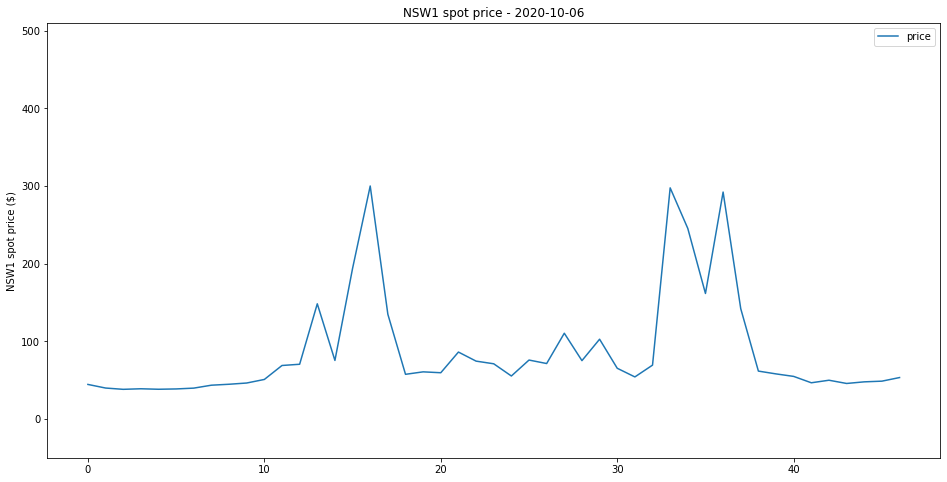

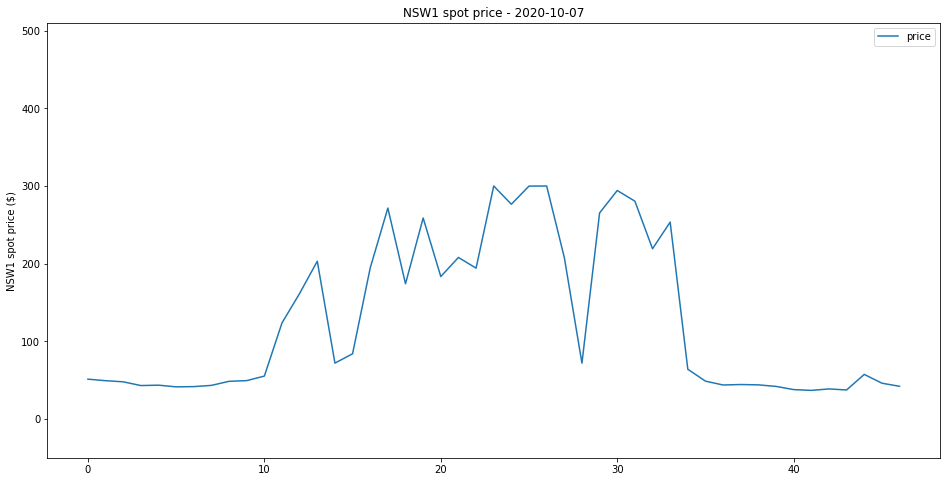

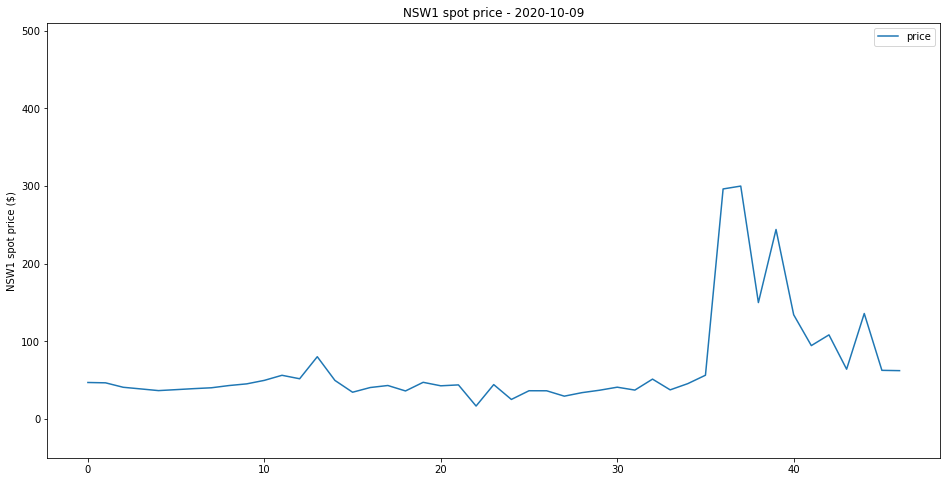

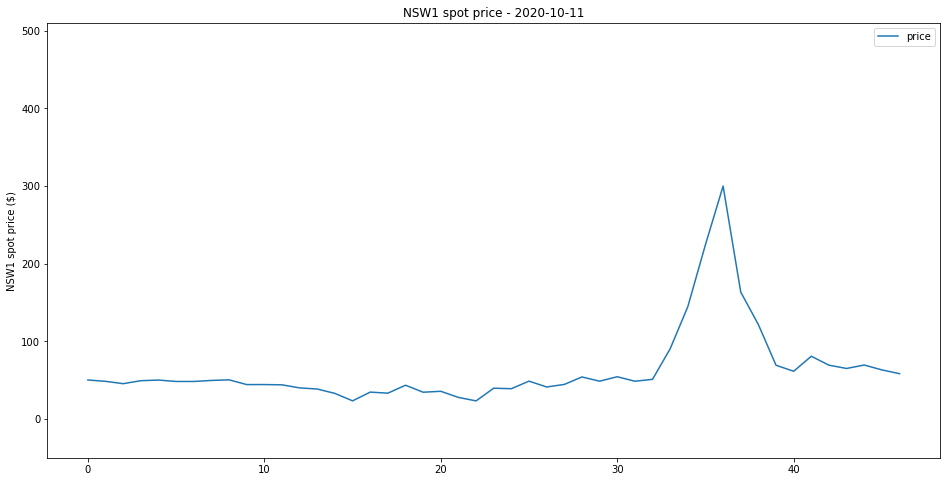

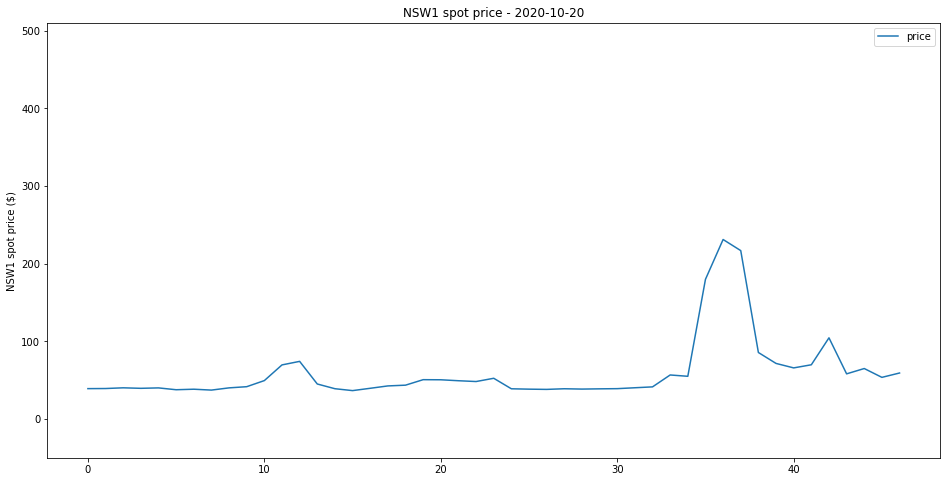

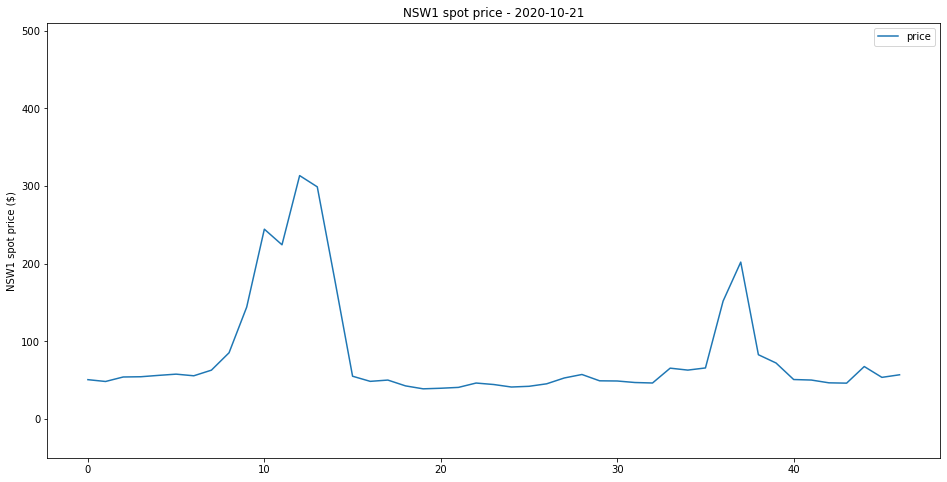

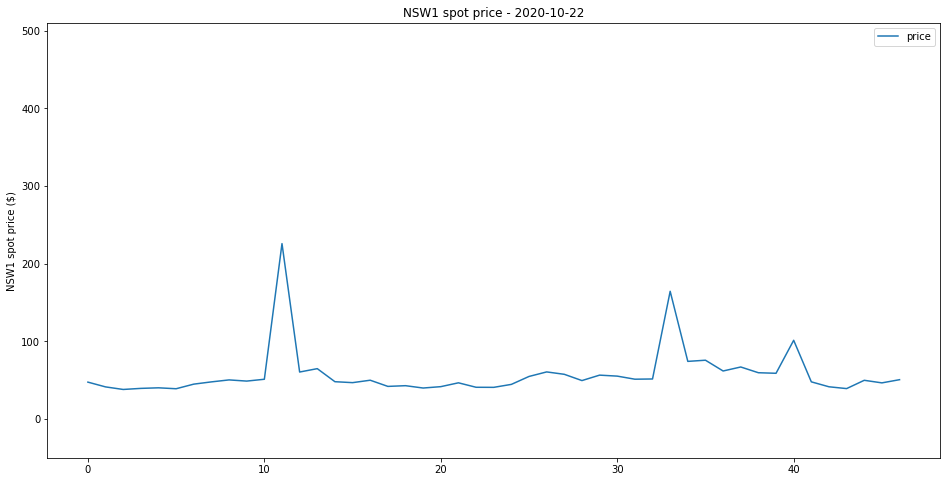

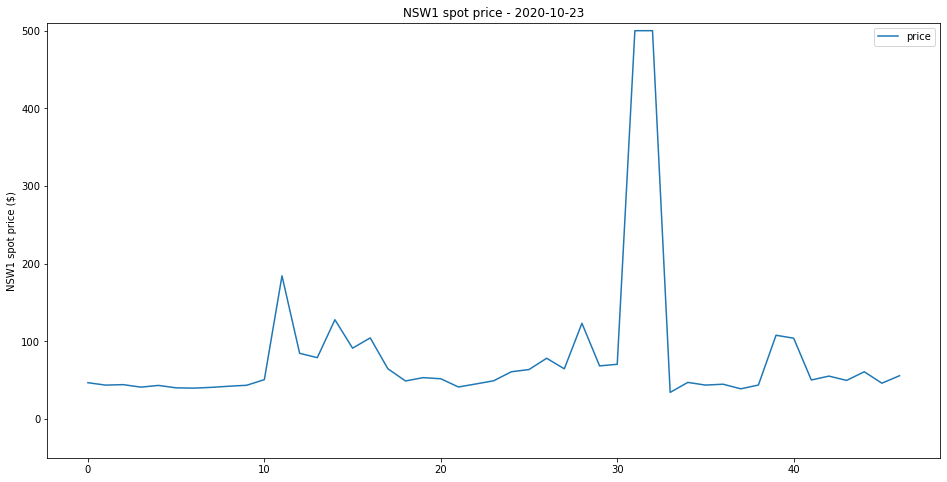

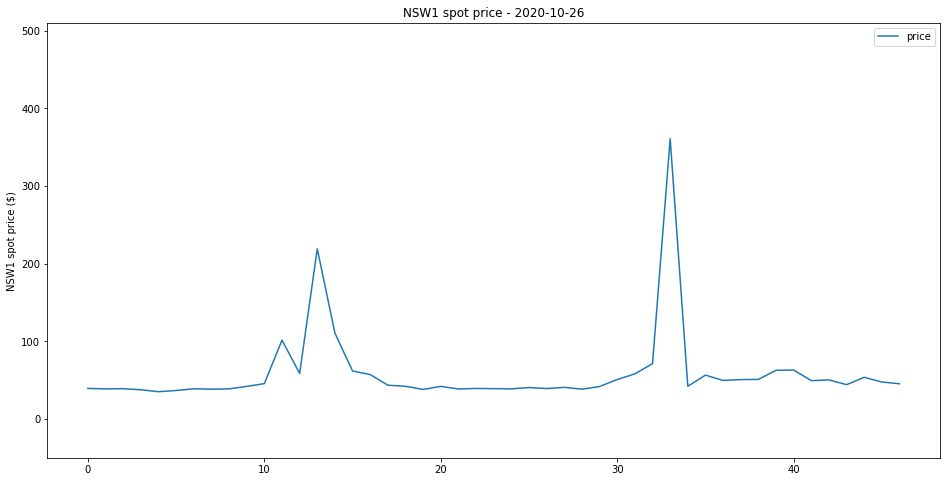

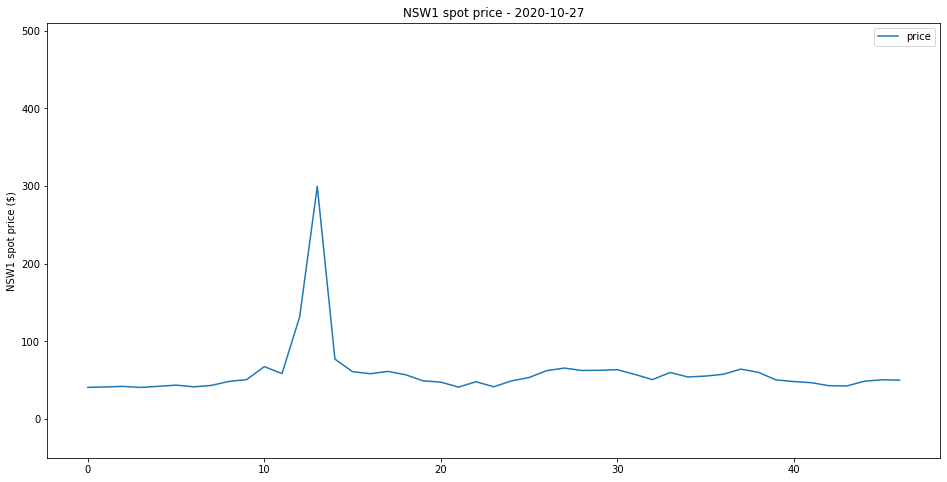

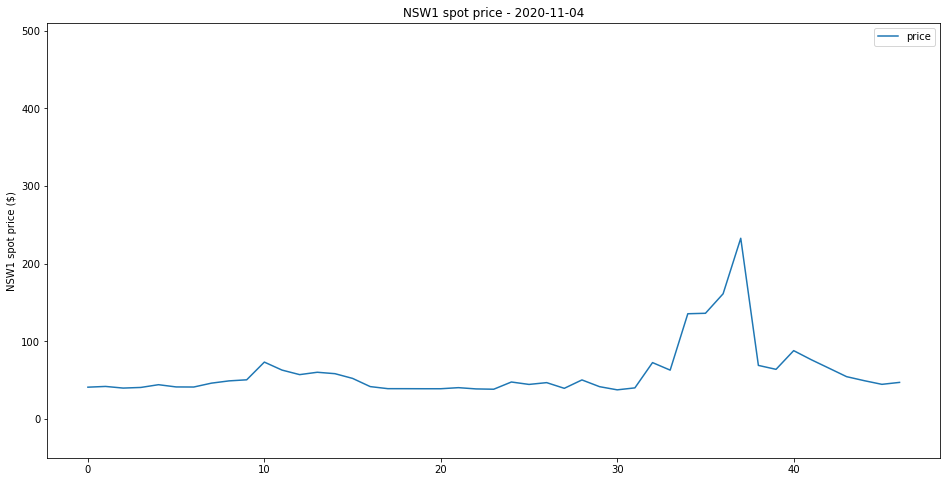

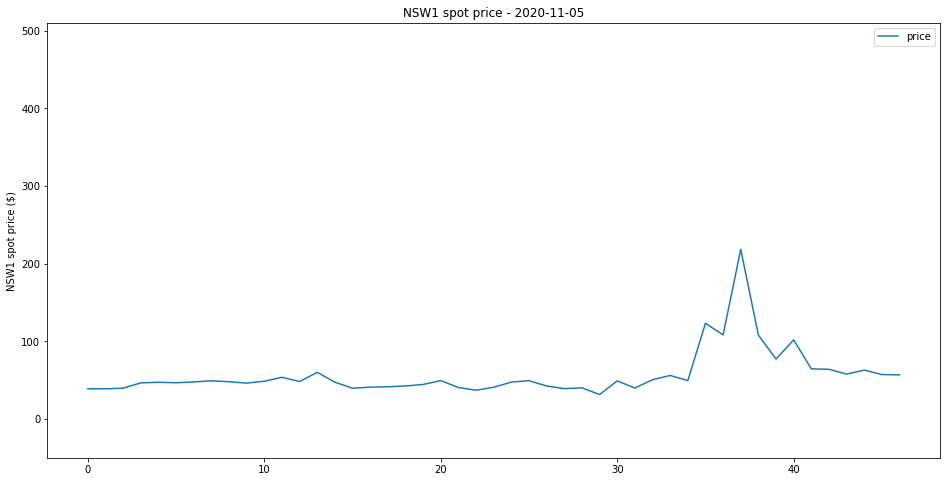

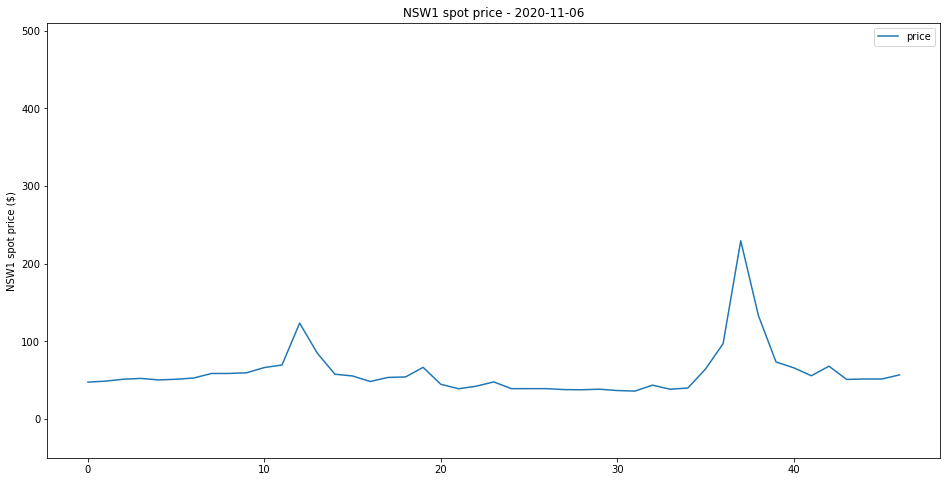

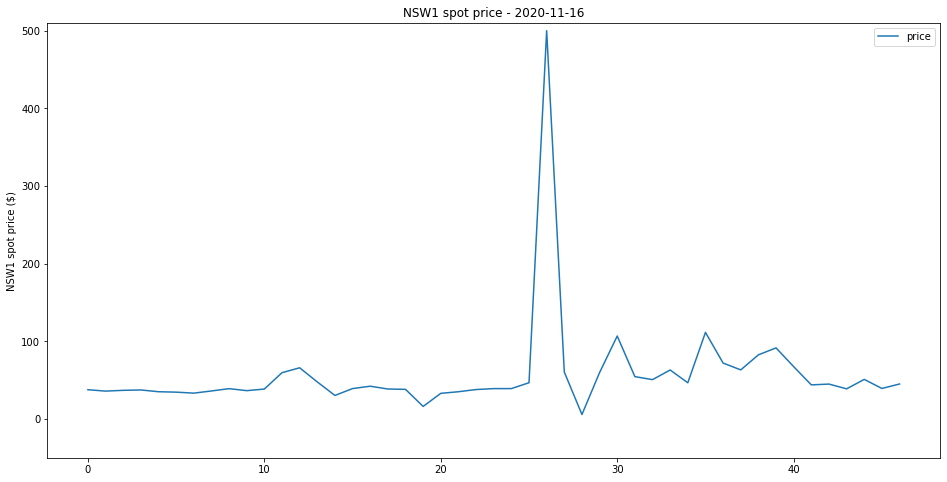

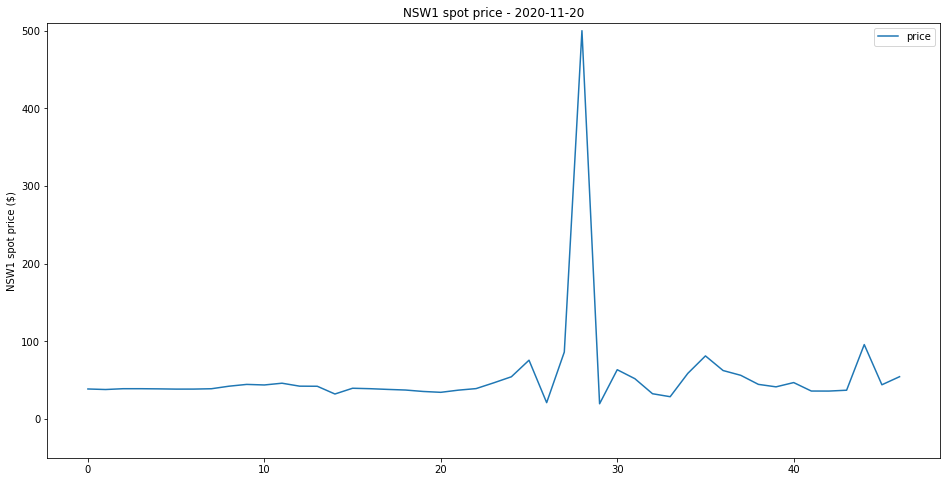

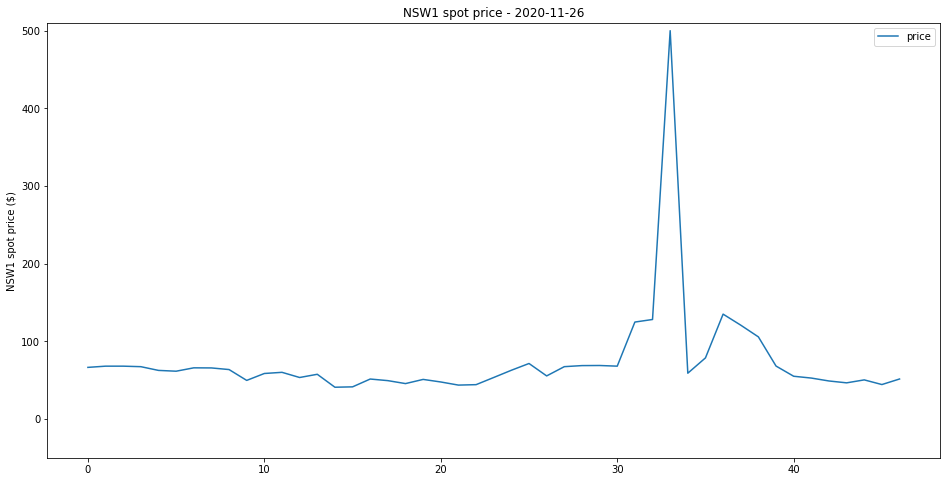

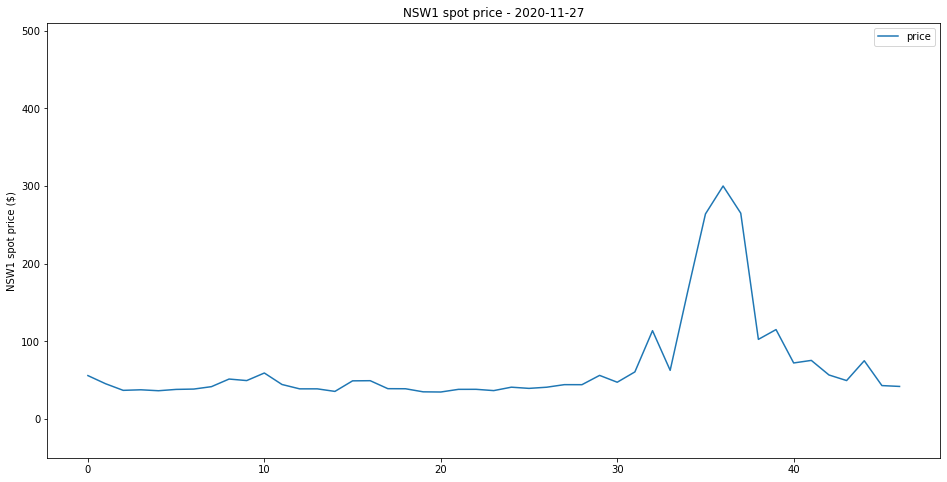

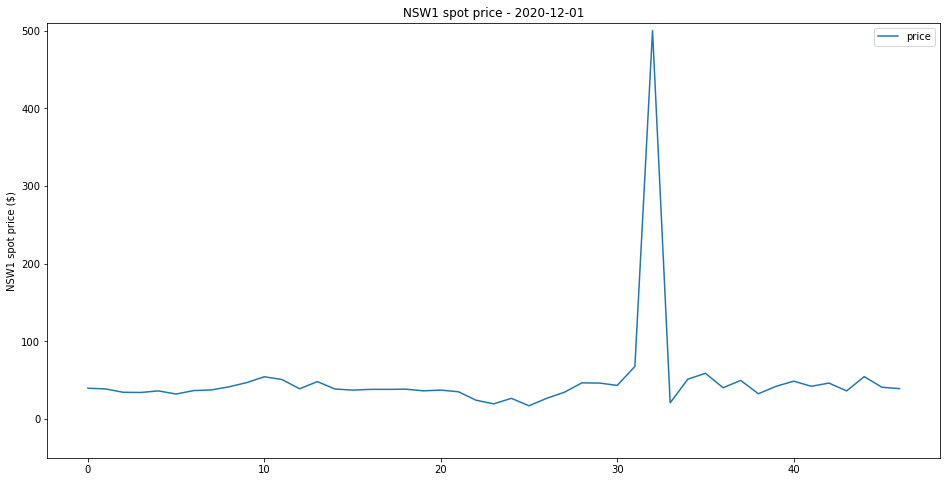

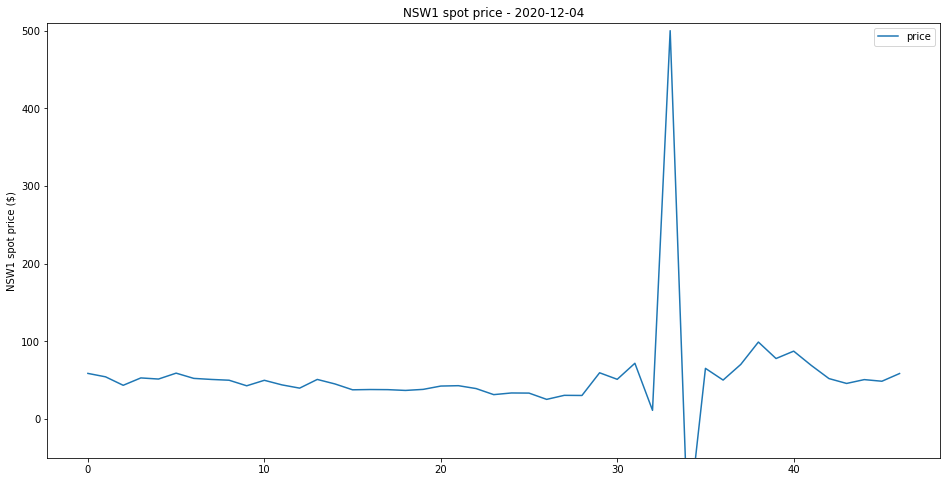

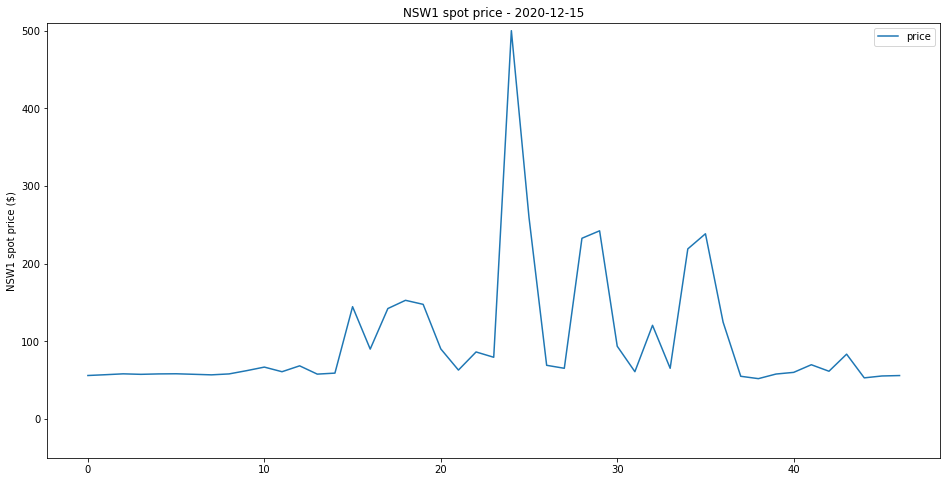

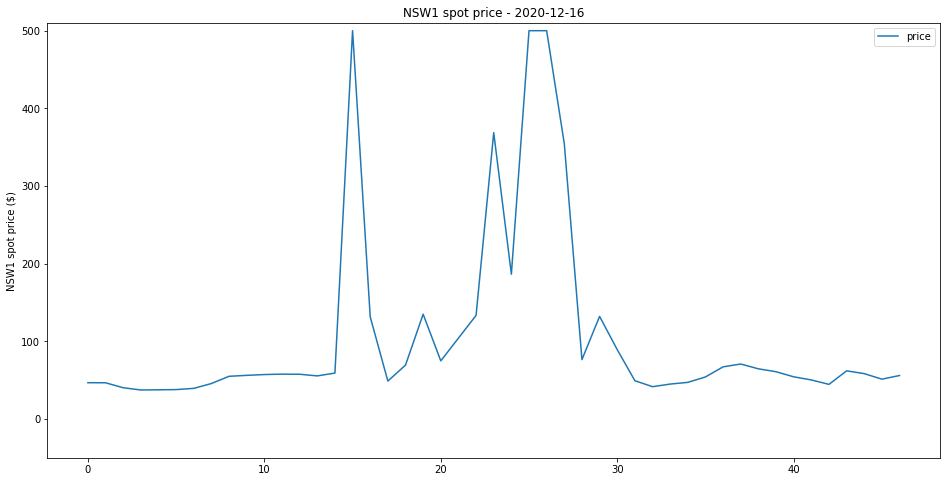

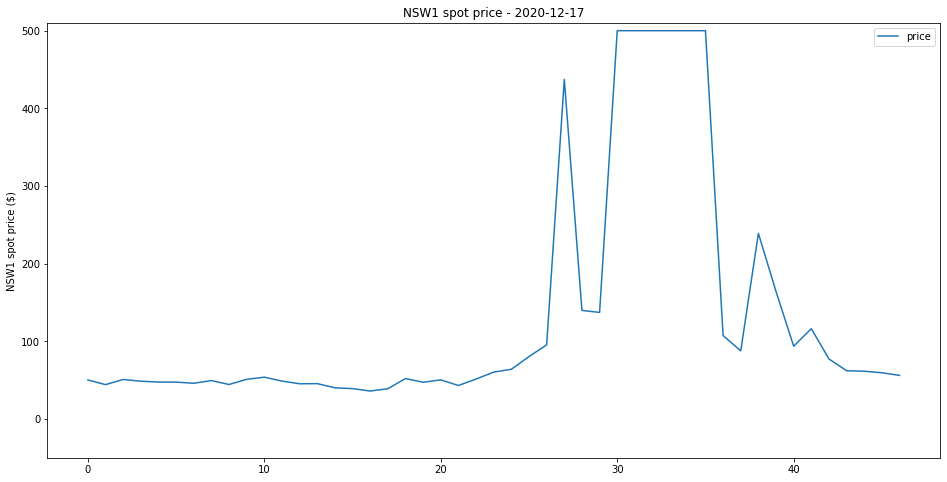

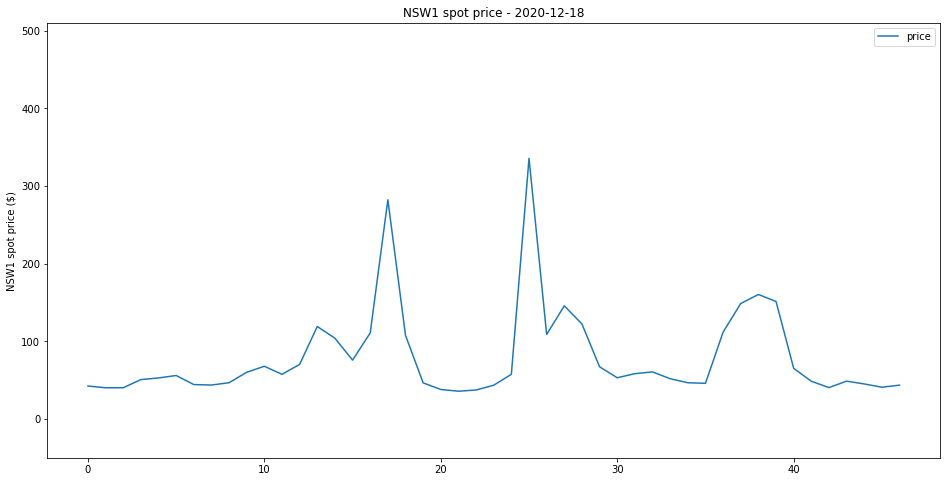

In [16]:
region = "NSW1"
for a,hp_day in enumerate(high_price_days[region]):
    fig, ax = plt.subplots(figsize=(16,8))
    ax.set_title(f'{region} spot price - {hp_day}')
    ax.set_ylabel(f'{region} spot price ($)')
    ax.set_ylim(-50,cap+10)
    start = pd.to_datetime(hp_day)
    end = pd.to_datetime(hp_day + dt.timedelta(days=1))
    day_spot_price = spot_price_capped[region][(spot_price_capped[region]["interval_start"]>start) & (spot_price_capped[region]["interval_start"]<end)]
    day_spot_price[["price"]].reset_index(drop=True, inplace=False).plot(ax=ax)

In [71]:
spot_price[region]

interval_start  price
0     2020-01-01 00:00:00  85.23
1     2020-01-01 00:30:00  64.76
2     2020-01-01 01:00:00  63.36
3     2020-01-01 01:30:00  65.21
4     2020-01-01 02:00:00  64.45
...                   ...    ...
17563 2020-12-31 21:30:00  35.57
17564 2020-12-31 22:00:00  46.35
17565 2020-12-31 22:30:00  40.80
17566 2020-12-31 23:00:00  48.16
17567 2020-12-31 23:30:00  46.25

[17568 rows x 2 columns]

# Exploration 

In [70]:
high_price_days

{'NSW1': array([datetime.date(2020, 1, 4), datetime.date(2020, 1, 20),
        datetime.date(2020, 1, 23), datetime.date(2020, 1, 28),
        datetime.date(2020, 1, 29), datetime.date(2020, 1, 30),
        datetime.date(2020, 1, 31), datetime.date(2020, 2, 1),
        datetime.date(2020, 2, 20), datetime.date(2020, 3, 30),
        datetime.date(2020, 4, 6), datetime.date(2020, 4, 12),
        datetime.date(2020, 4, 13), datetime.date(2020, 5, 4),
        datetime.date(2020, 5, 25), datetime.date(2020, 5, 27),
        datetime.date(2020, 5, 28), datetime.date(2020, 6, 5),
        datetime.date(2020, 6, 8), datetime.date(2020, 6, 9),
        datetime.date(2020, 6, 10), datetime.date(2020, 6, 11),
        datetime.date(2020, 6, 17), datetime.date(2020, 6, 23),
        datetime.date(2020, 7, 6), datetime.date(2020, 7, 21),
        datetime.date(2020, 7, 22), datetime.date(2020, 7, 23),
        datetime.date(2020, 8, 14), datetime.date(2020, 8, 24),
        datetime.date(2020, 8, 25), date

<ipython-input-65-3c9bd3200a3e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nsw_spot_price_2020["date"] = pd.to_datetime(nsw_spot_price_2020.index).date
<ipython-input-65-3c9bd3200a3e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nsw_spot_price_2020["date"] = pd.to_datetime(nsw_spot_price_2020.index).date
<ipython-input-65-3c9bd3200a3e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

ValueError: not enough values to unpack (expected 2, got 0)

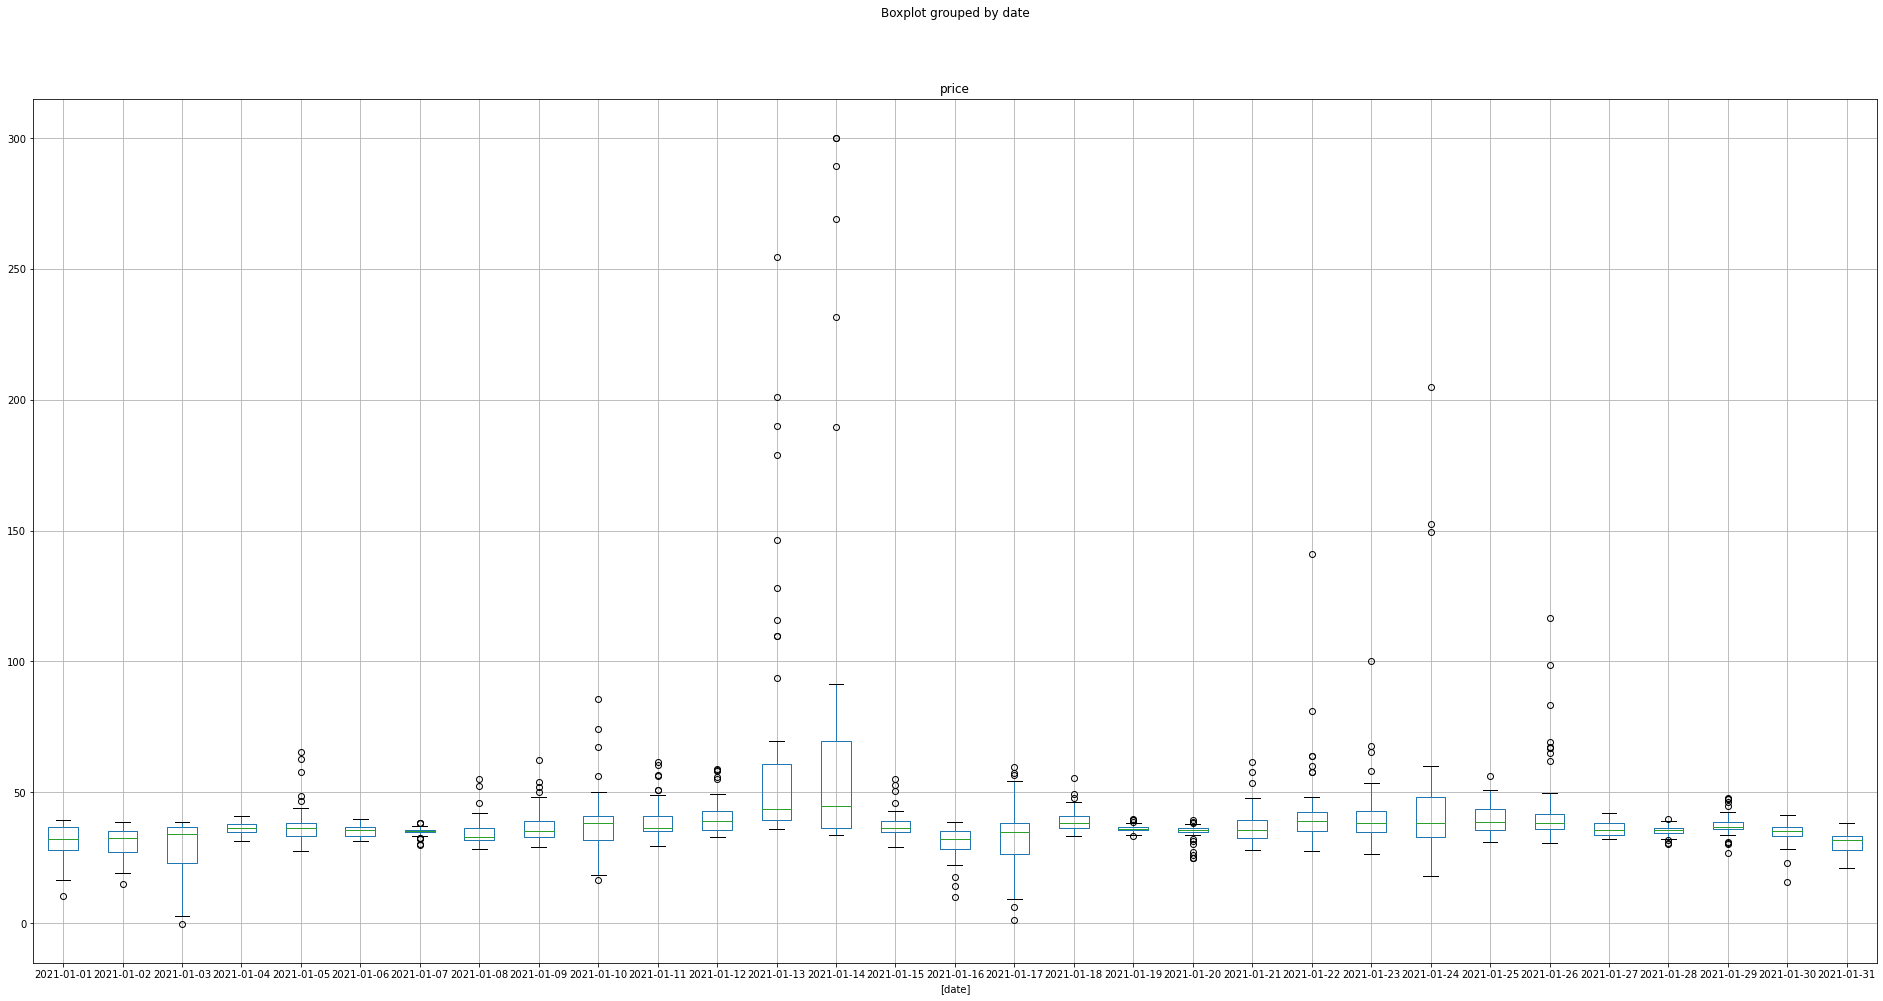

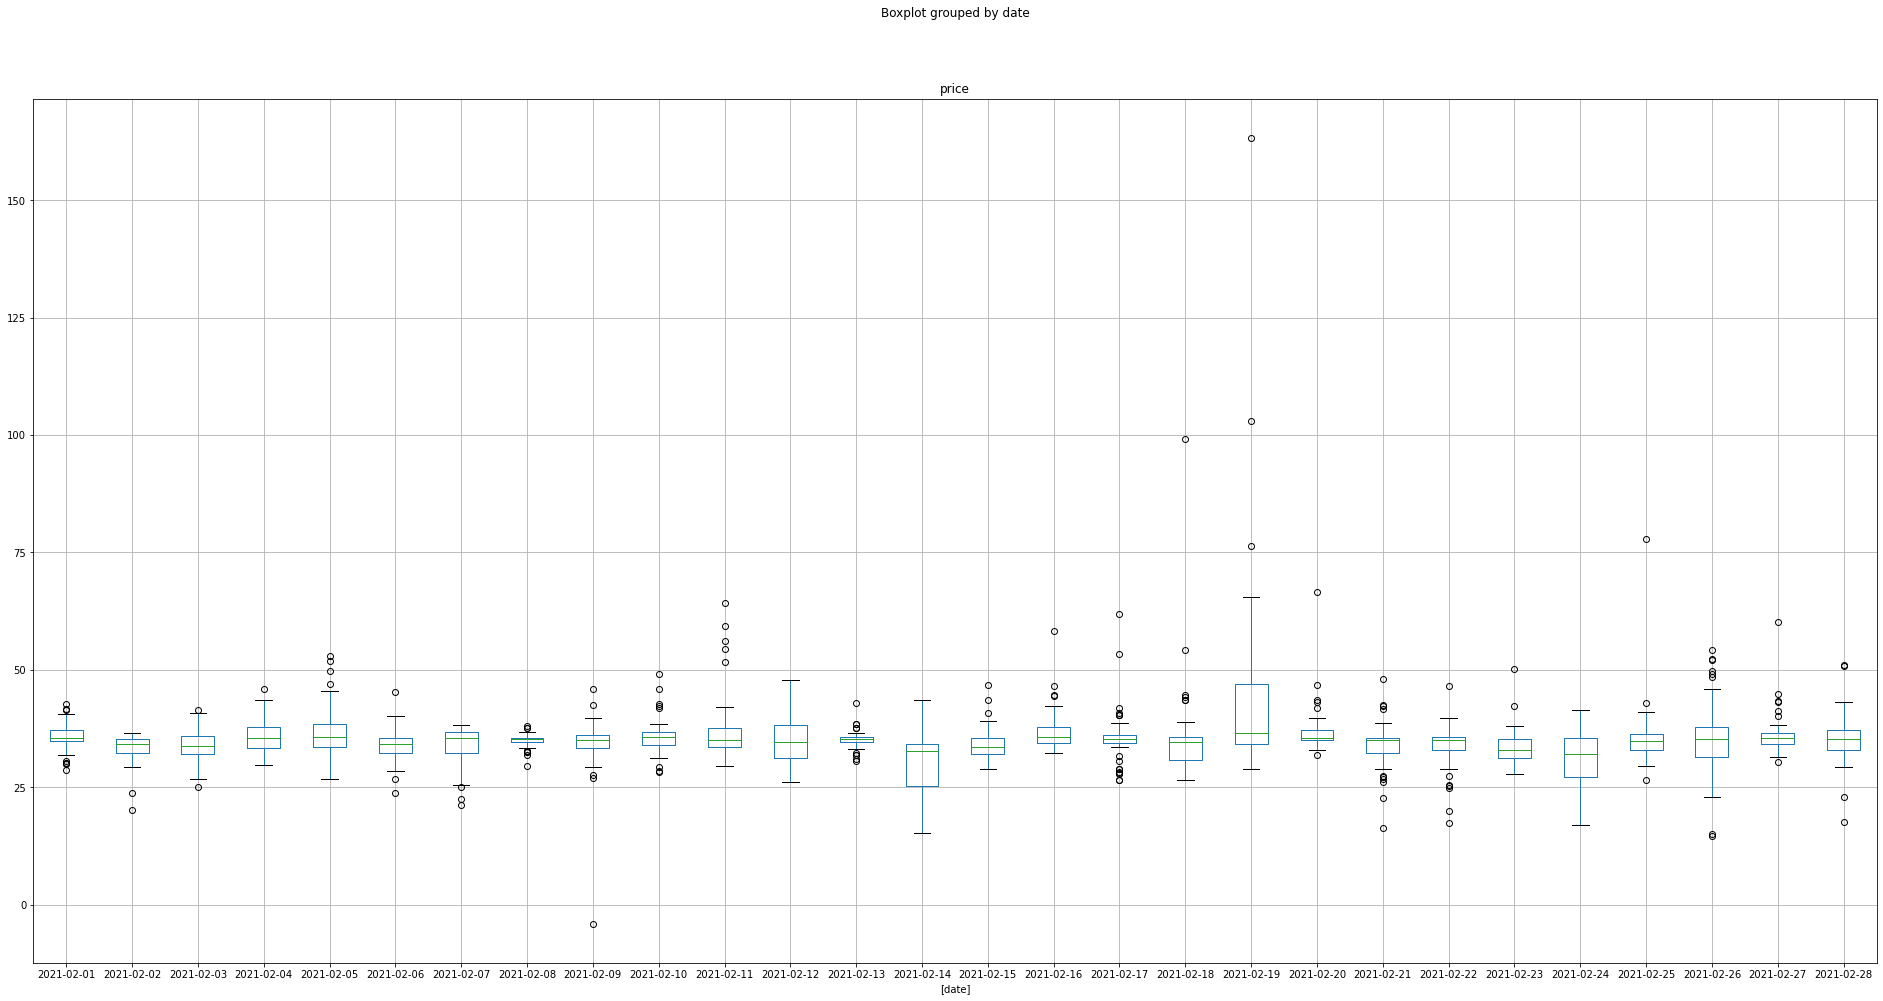

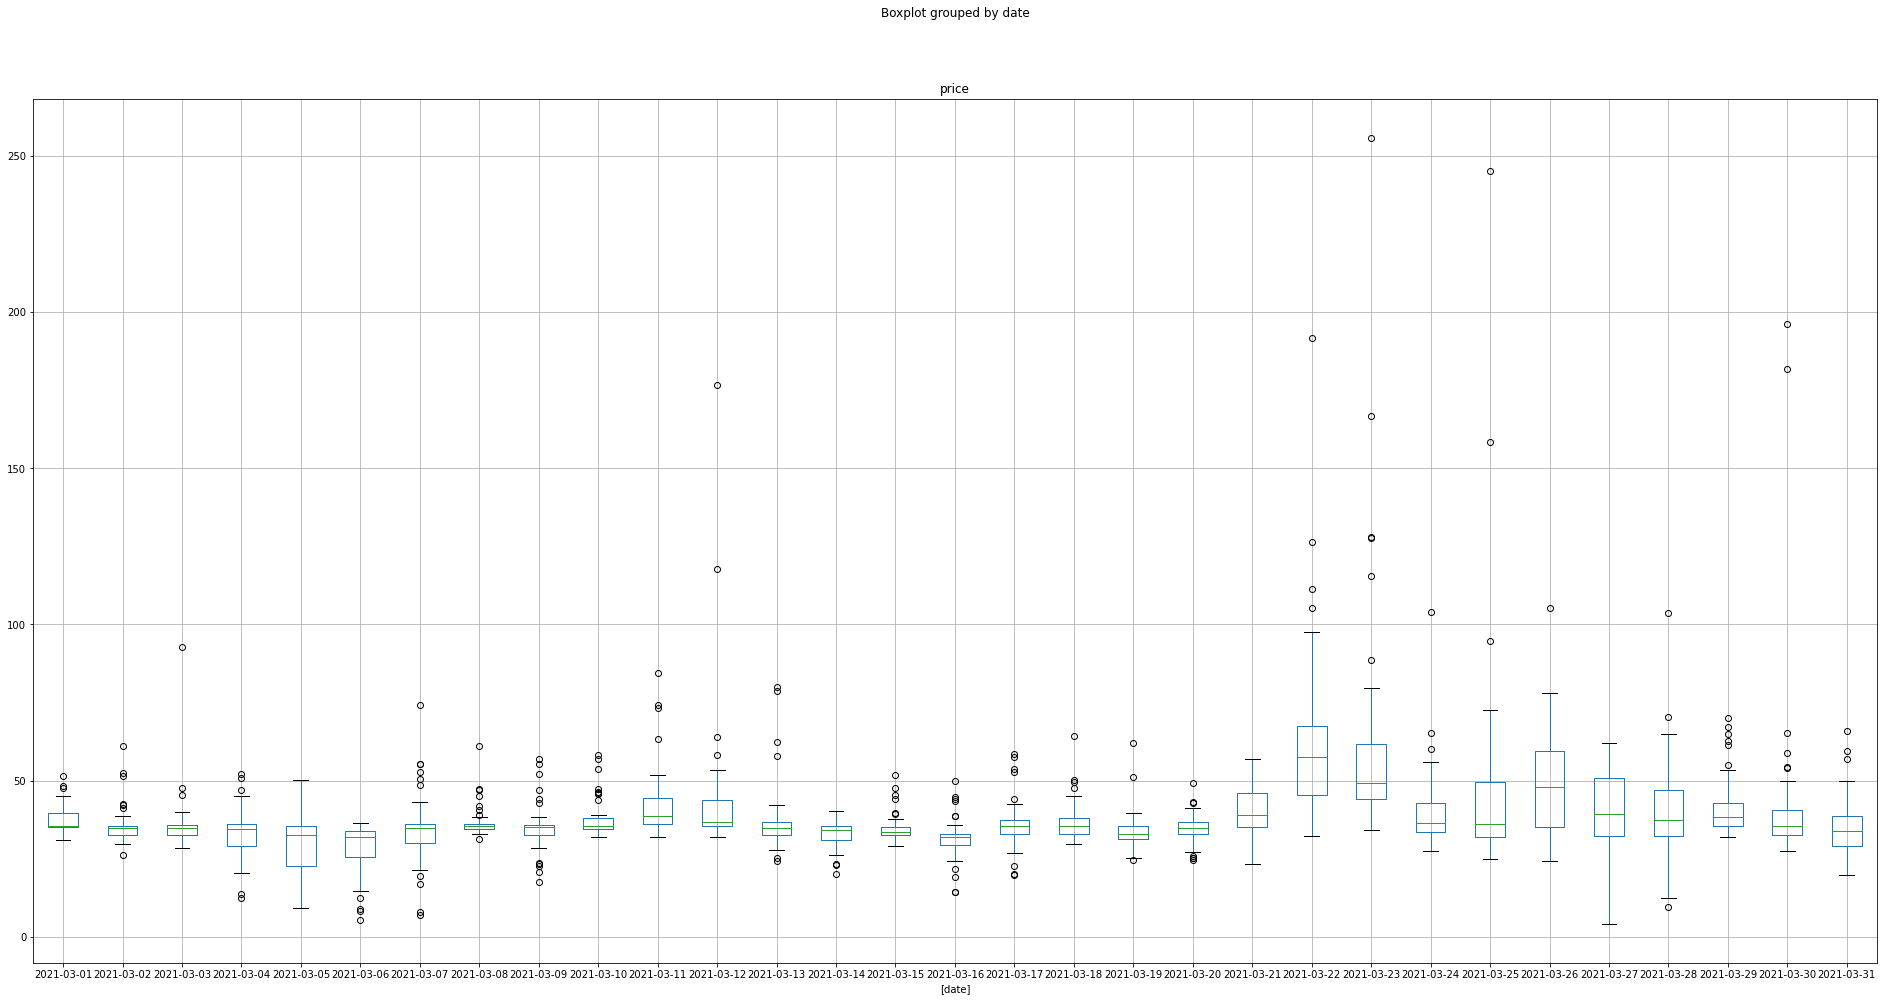

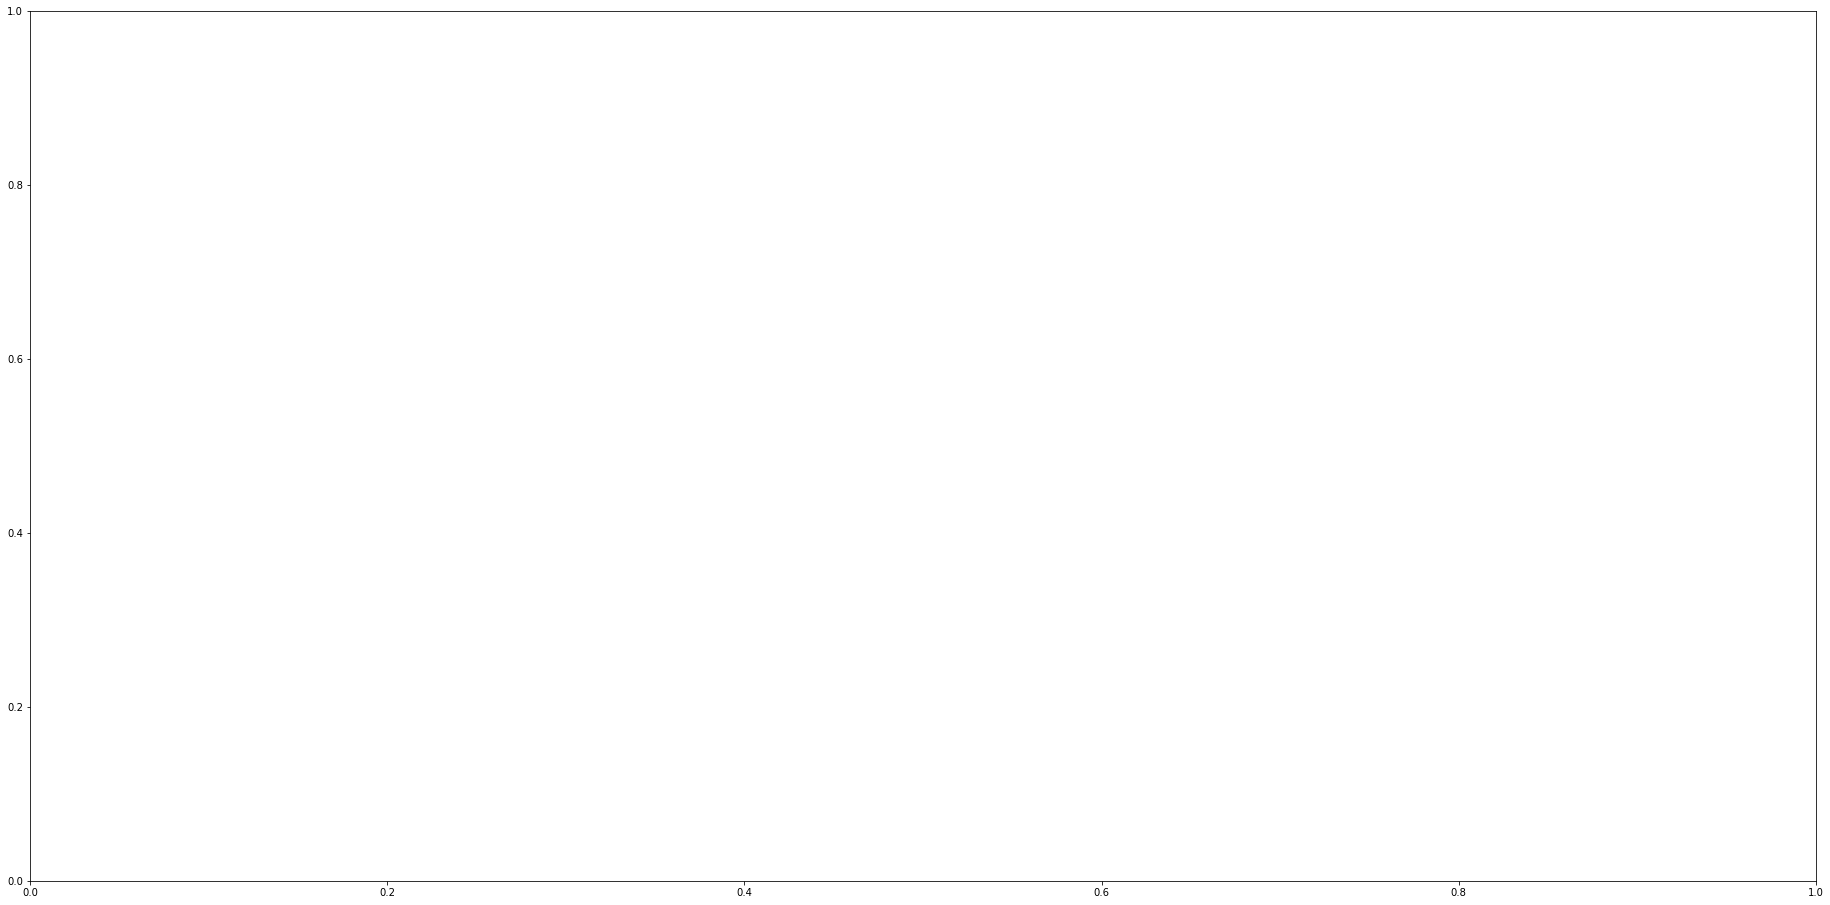

In [65]:
for m in range(12):
    nsw_spot_price_2020 = nsw_spot_price[(nsw_spot_price.index>dt.datetime(2021,m+1,1)) & (nsw_spot_price.index<dt.datetime(2021,m+2,1))]
    nsw_spot_price_2020["date"] = pd.to_datetime(nsw_spot_price_2020.index).date
    nsw_spot_price_2020.boxplot(by="date",figsize=(32,16))

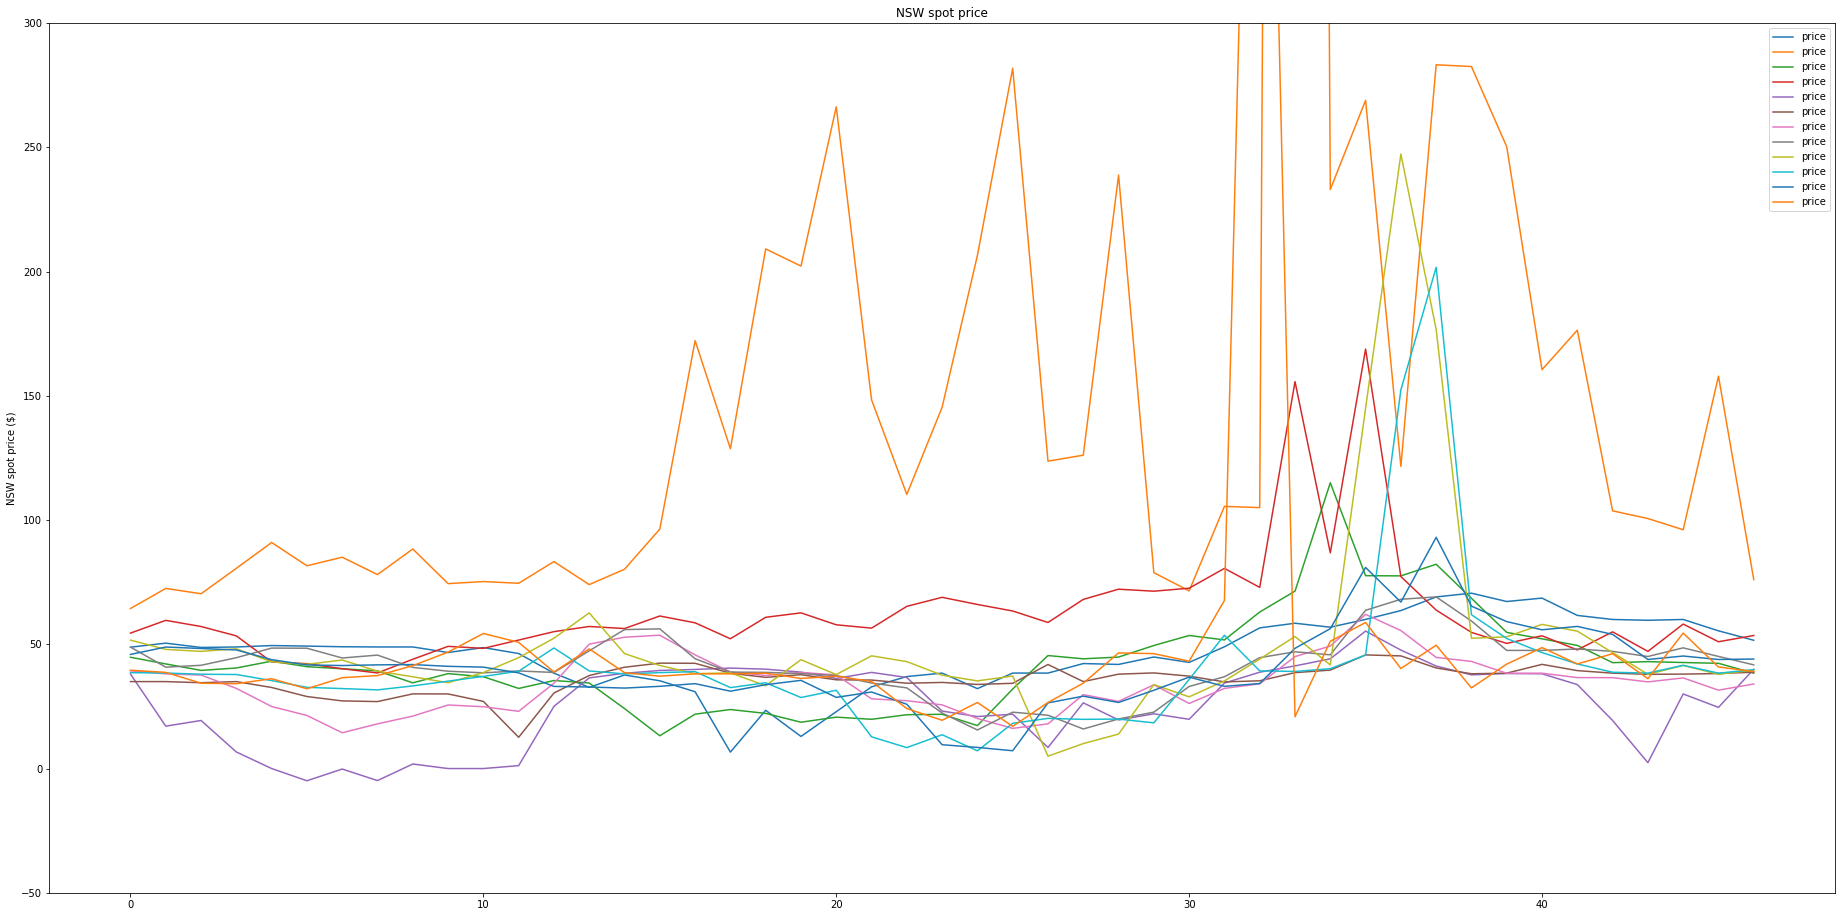

In [43]:
fig, ax = plt.subplots(figsize=(32,16))
ax.set_title('NSW spot price')
ax.set_ylabel('NSW spot price ($)')
ax.set_ylim(-50,300)
for m in range(12):
    start = dt.datetime(2020,m+1,1)
    end = dt.datetime(2020,m+1,2)
    day_spot_price = nsw_spot_price[(nsw_spot_price.index>start) & (nsw_spot_price.index<end)]
    day_spot_price[["price"]].reset_index(drop=True, inplace=False).plot(ax=ax)


In [80]:
start = dt.datetime(2020,1,1)
end = dt.datetime(2021,1,1)
nsw_spot_price_quantiles = [nsw_spot_price[(nsw_spot_price.index>start) & (nsw_spot_price.index<end)]["price"].quantile(0.99+q/100000) for q in range(1000)]

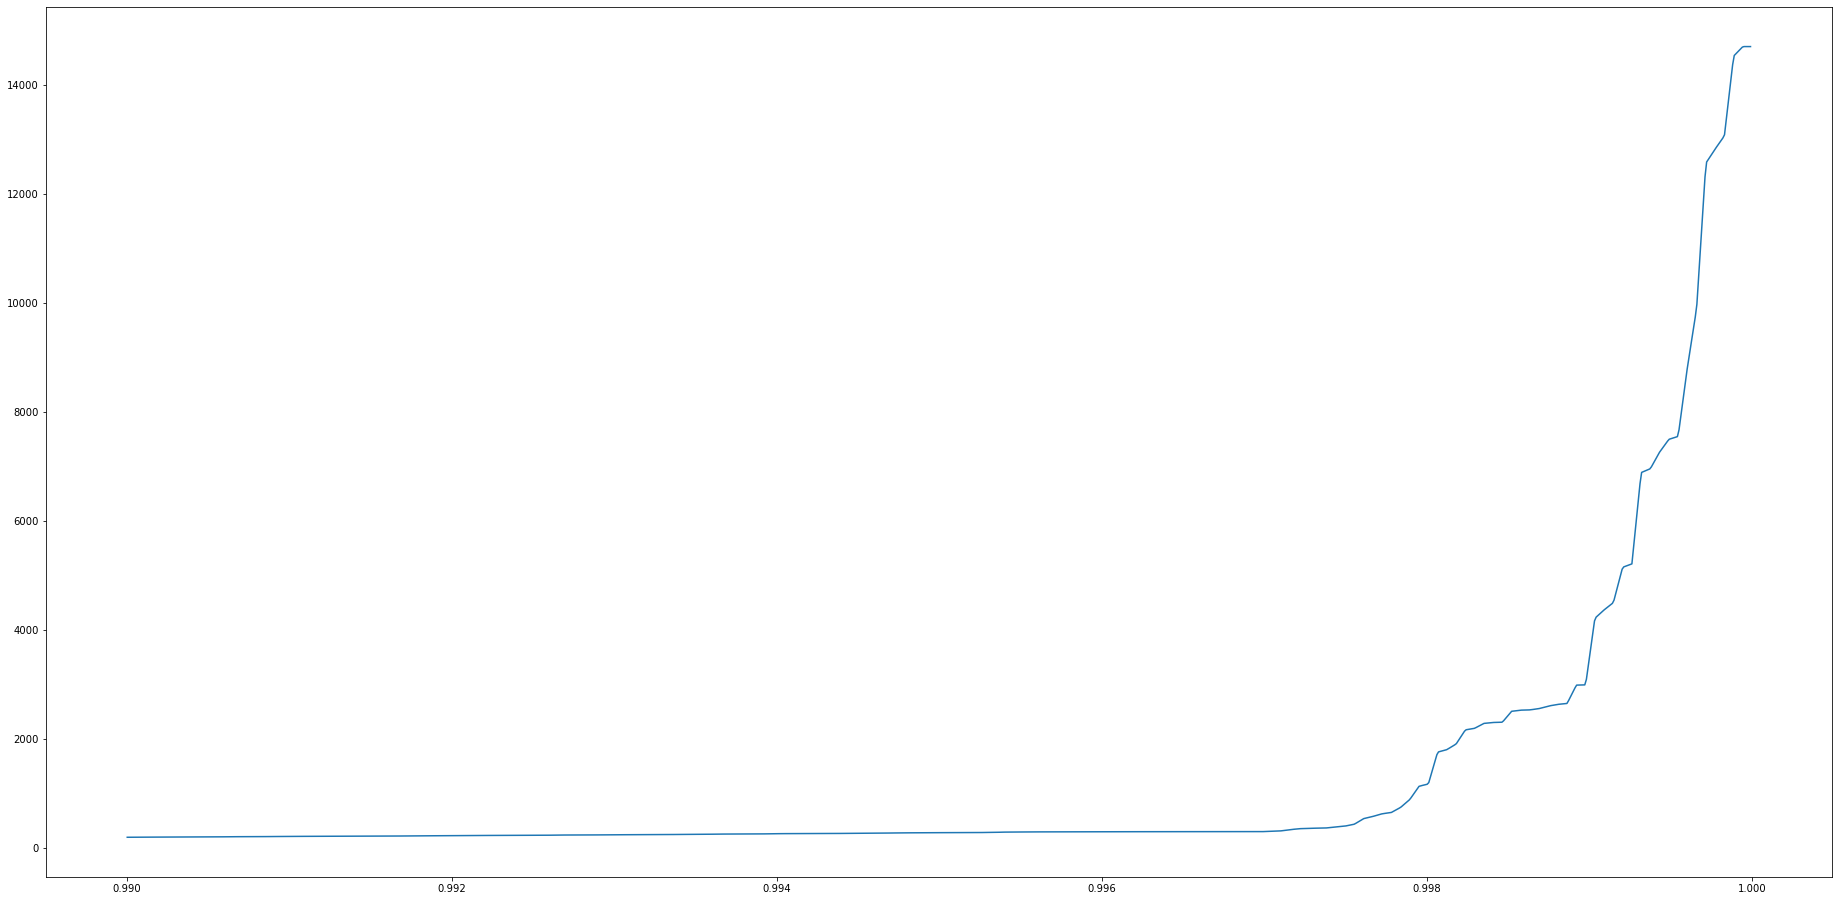

In [81]:
fig, ax = plt.subplots(figsize=(32,16))
ax.plot([0.99+q/100000 for q in range(1000)], nsw_spot_price_quantiles)

In [83]:
(24*2*365)*0.002

35.04

In [87]:
10000/50

200.0

In [86]:
nsw_spot_price[(nsw_spot_price.index>start) & (nsw_spot_price.index<end) & (nsw_spot_price["price"]>1800)]["price"]

interval_start
2020-01-04 16:00:00     9900.0
2020-01-04 16:30:00    14525.0
2020-01-04 17:00:00    14700.0
2020-01-04 17:30:00    14700.0
2020-01-04 18:00:00     5149.0
2020-01-23 14:30:00     2508.0
2020-01-23 17:30:00     2652.0
2020-01-23 19:00:00     2635.0
2020-01-30 18:00:00     1805.0
2020-01-31 14:30:00     2308.0
2020-01-31 15:00:00     7263.0
2020-01-31 15:30:00    13063.0
2020-01-31 16:00:00     2167.0
2020-01-31 16:30:00     6958.0
2020-01-31 17:00:00    12562.0
2020-01-31 17:30:00     4368.0
2020-01-31 18:00:00    12821.0
2020-01-31 18:30:00     6886.0
2020-02-01 17:00:00     2559.0
2020-06-09 18:00:00     2196.0
2020-08-24 18:30:00     1908.0
2020-10-23 16:00:00     2303.0
2020-10-23 16:30:00     4502.0
2020-11-16 13:30:00     7496.0
2020-11-20 14:30:00     7550.0
2020-11-26 17:00:00     2534.0
2020-12-04 17:00:00     2286.0
2020-12-16 13:00:00     2529.0
2020-12-16 13:30:00     2605.0
2020-12-17 15:30:00     5210.0
2020-12-17 16:00:00     8815.0
2020-12-17 16:30:00     

# Year

<AxesSubplot:title={'center':'NSW long run aggregate power'}, xlabel='interval_start', ylabel='Aggergate production (MW)'>

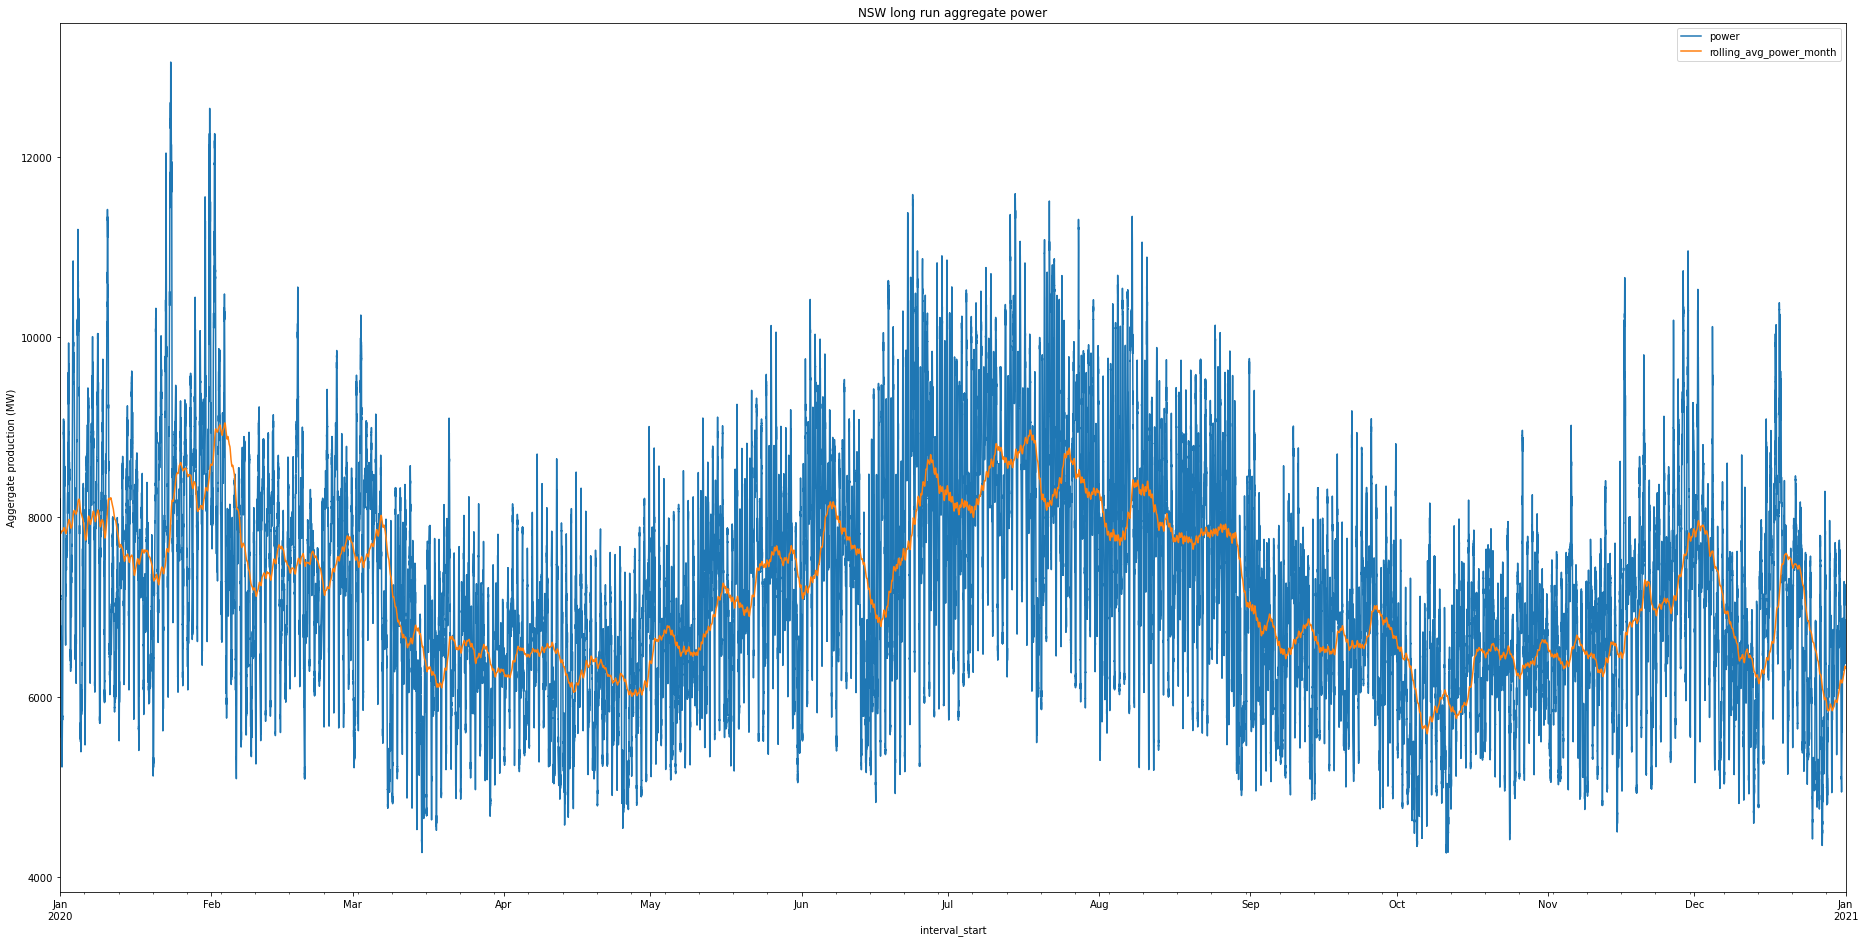

In [18]:
fig, ax = plt.subplots(figsize=(32,16))
ax.set_title('NSW long run aggregate power')
ax.set_ylabel('Aggergate production (MW)')
nsw_aggregate_power_df[["power","rolling_avg_power_month"]][(nsw_aggregate_power_df.index >= '2020-01-01') & (nsw_aggregate_power_df.index <= '2021-01-01')].plot(ax=ax)

# Month

<AxesSubplot:title={'center':'NSW long run aggregate power'}, xlabel='interval_start', ylabel='Aggergate production (MW)'>

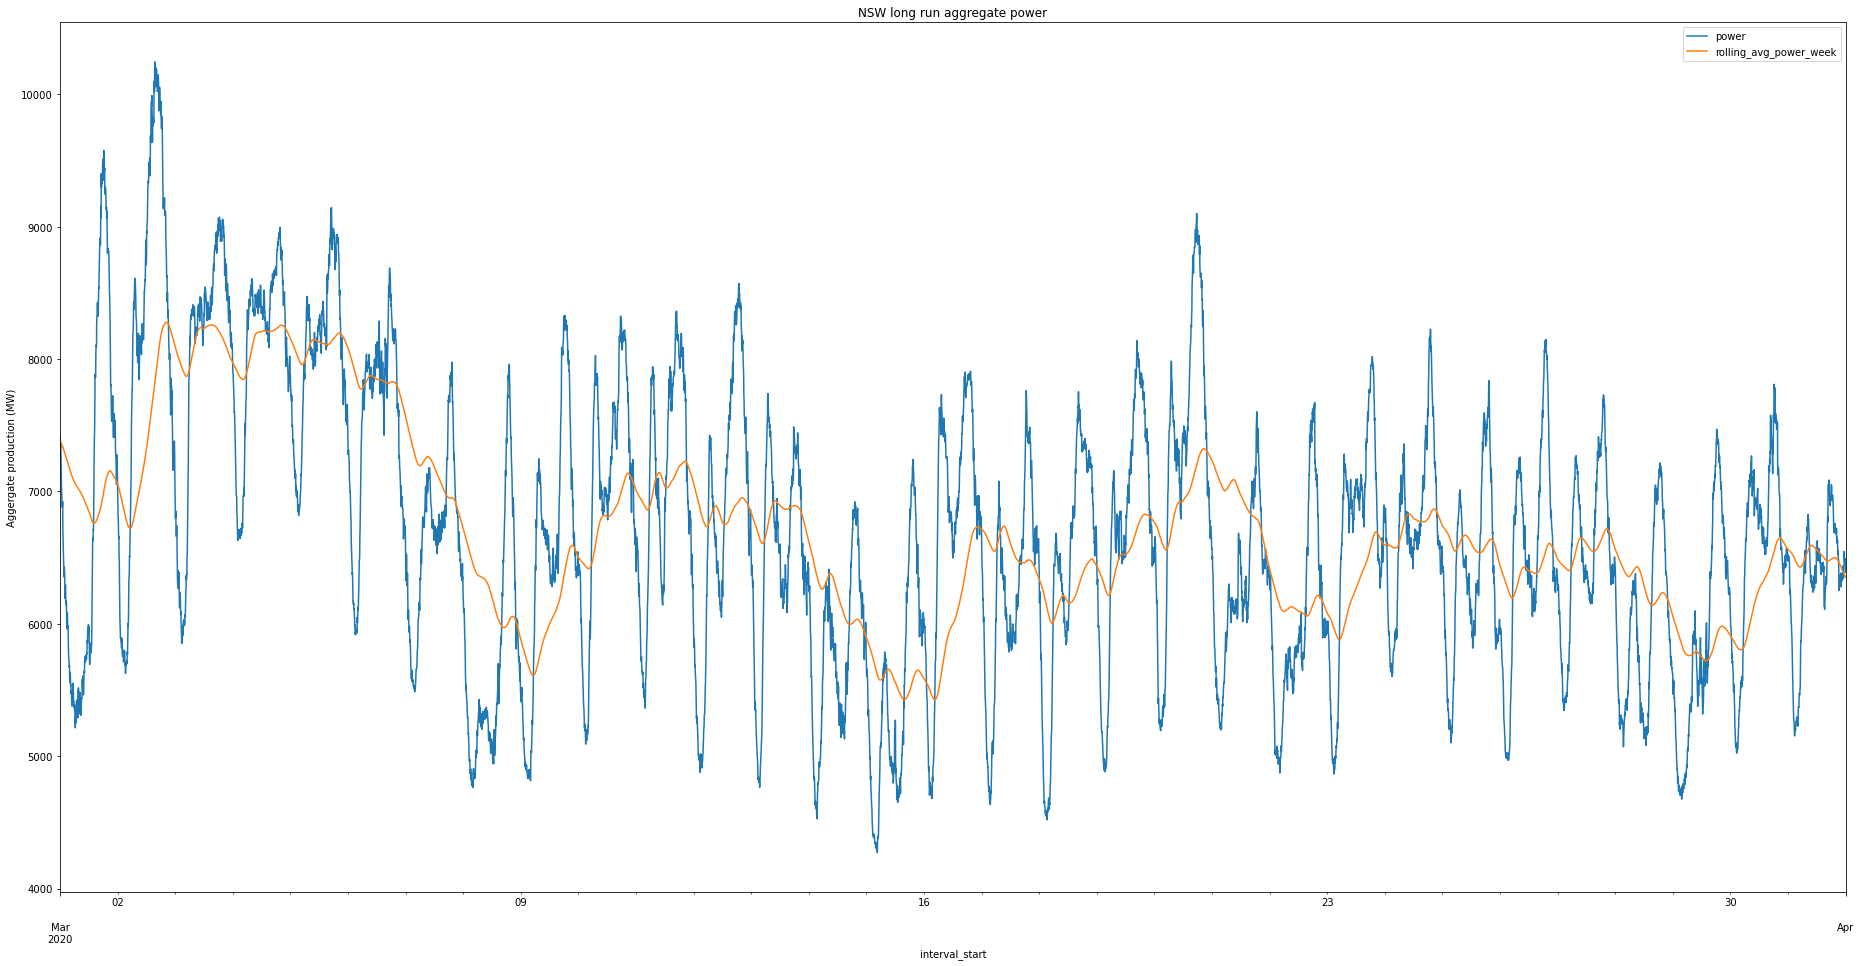

In [22]:
fig, ax = plt.subplots(figsize=(32,16))
ax.set_title('NSW long run aggregate power')
ax.set_ylabel('Aggergate production (MW)')
nsw_aggregate_power_df[["power","rolling_avg_power_week"]][(nsw_aggregate_power_df.index >= '2020-03-01') & (nsw_aggregate_power_df.index <= '2020-04-01')].plot(ax=ax)

# Week

<AxesSubplot:title={'center':'NSW long run aggregate power'}, xlabel='interval_start', ylabel='Aggergate production (MW)'>

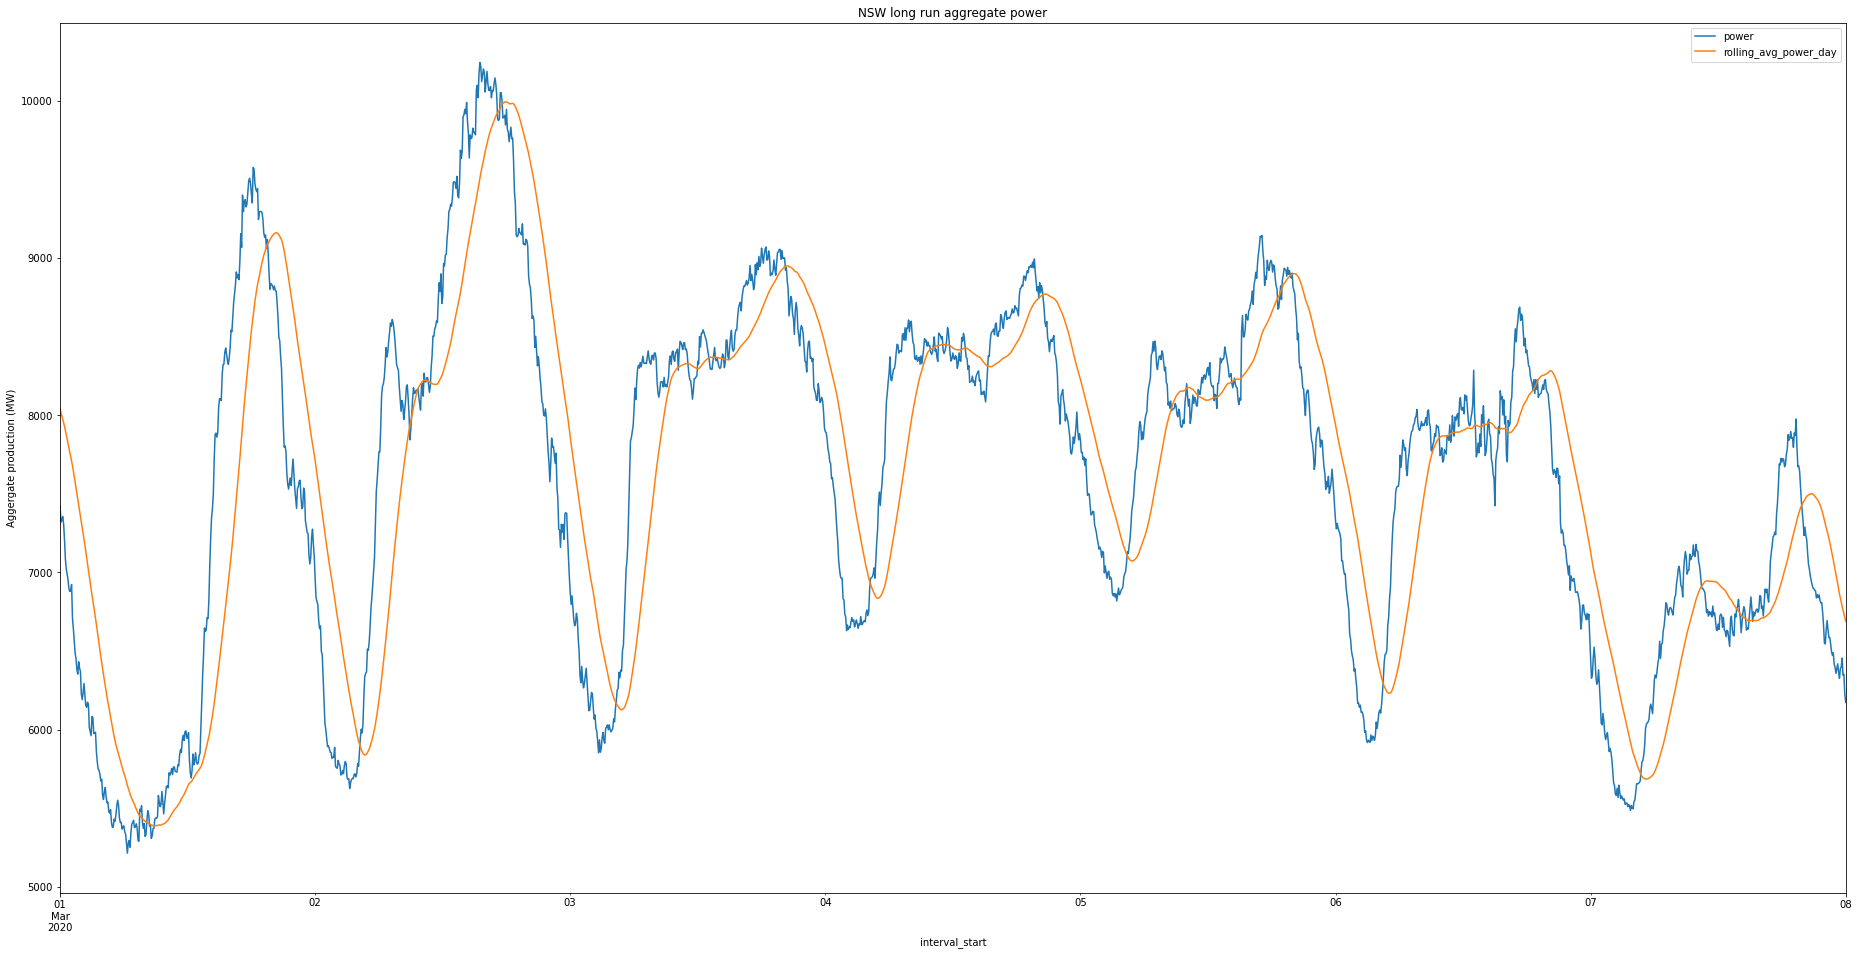

In [20]:
fig, ax = plt.subplots(figsize=(32,16))
ax.set_title('NSW long run aggregate power')
ax.set_ylabel('Aggergate production (MW)')
nsw_aggregate_power_df[["power","rolling_avg_power_day"]][(nsw_aggregate_power_df.index >= '2020-03-01') & (nsw_aggregate_power_df.index <= '2020-03-08')].plot(ax=ax)

# Day

<AxesSubplot:title={'center':'NSW long run aggregate power'}, xlabel='interval_start', ylabel='Aggergate production (MW)'>

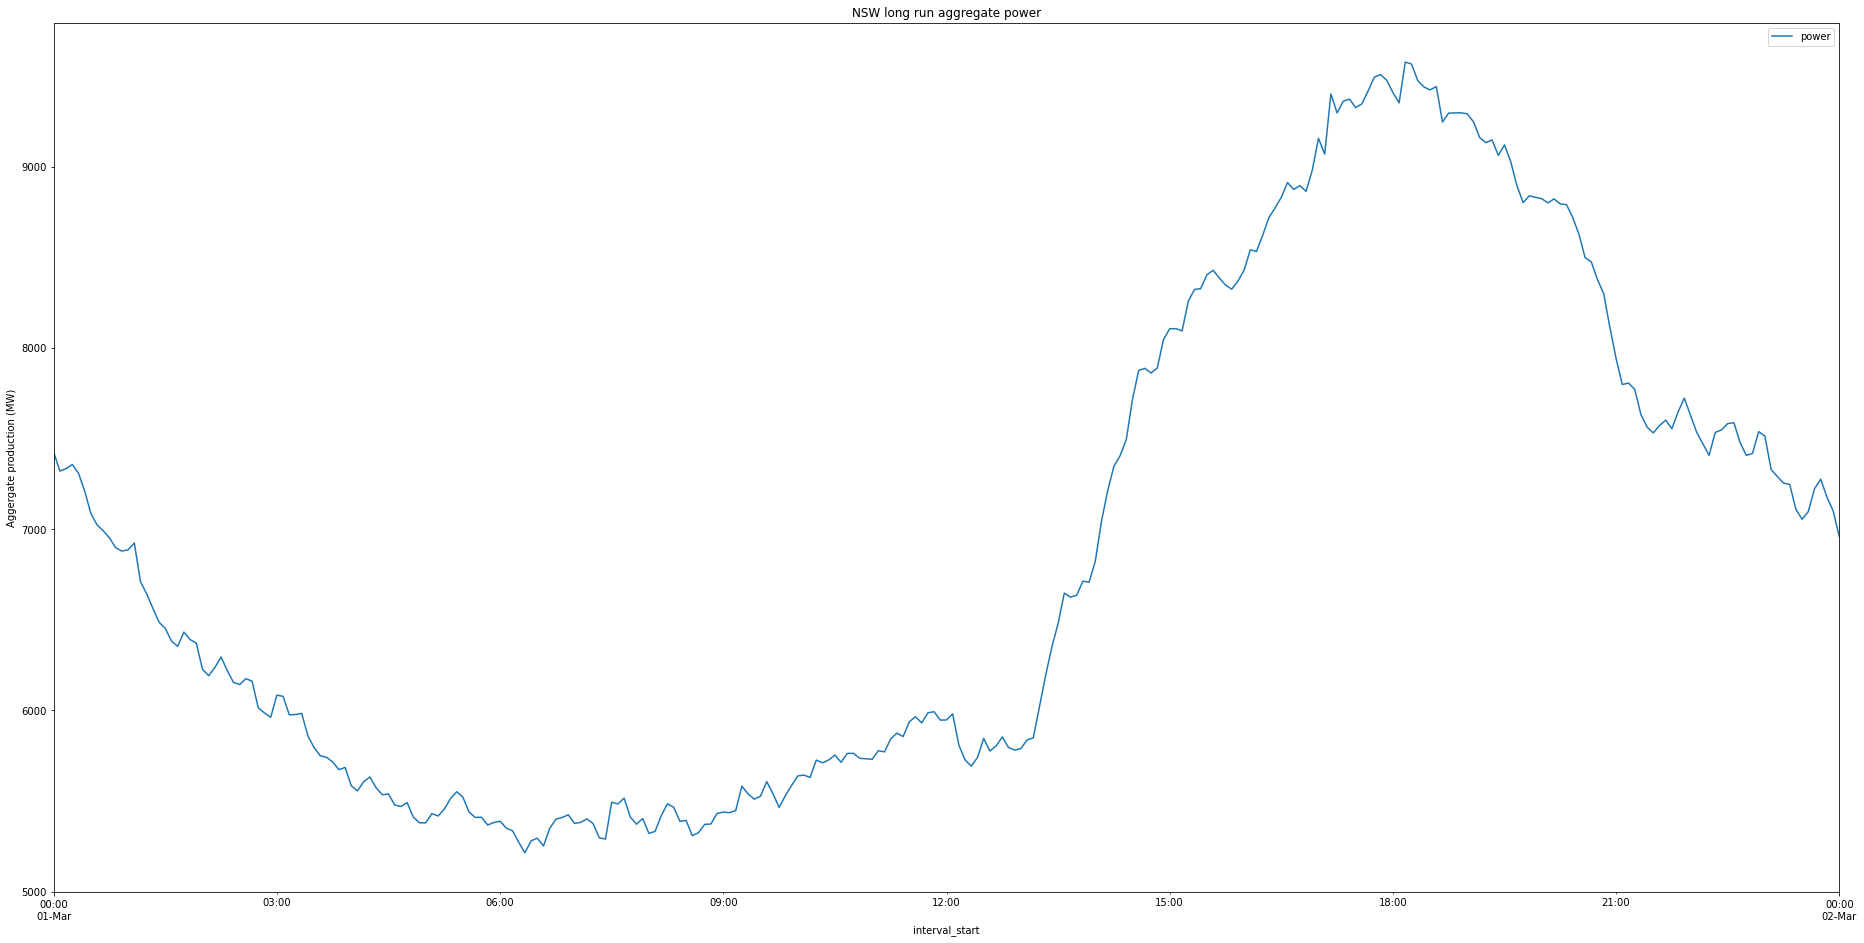

In [75]:
fig, ax = plt.subplots(figsize=(32,16))
ax.set_title('NSW long run aggregate power')
ax.set_ylabel('Aggergate production (MW)')
nsw_aggregate_power_df[(nsw_aggregate_power_df.index >= '2020-03-01') & (nsw_aggregate_power_df.index <= '2020-03-02')].plot(ax=ax)